In [1]:
import mujoco_py
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import *
from util import *
from util_fk import *
import cv2

np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Done.
Ready.


In [2]:
# env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/UR5_rg2_gripper.xml')
env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/ril_robot.xml')
print ("[%s] parsed."%(env.name))

[UR5e] parsed.


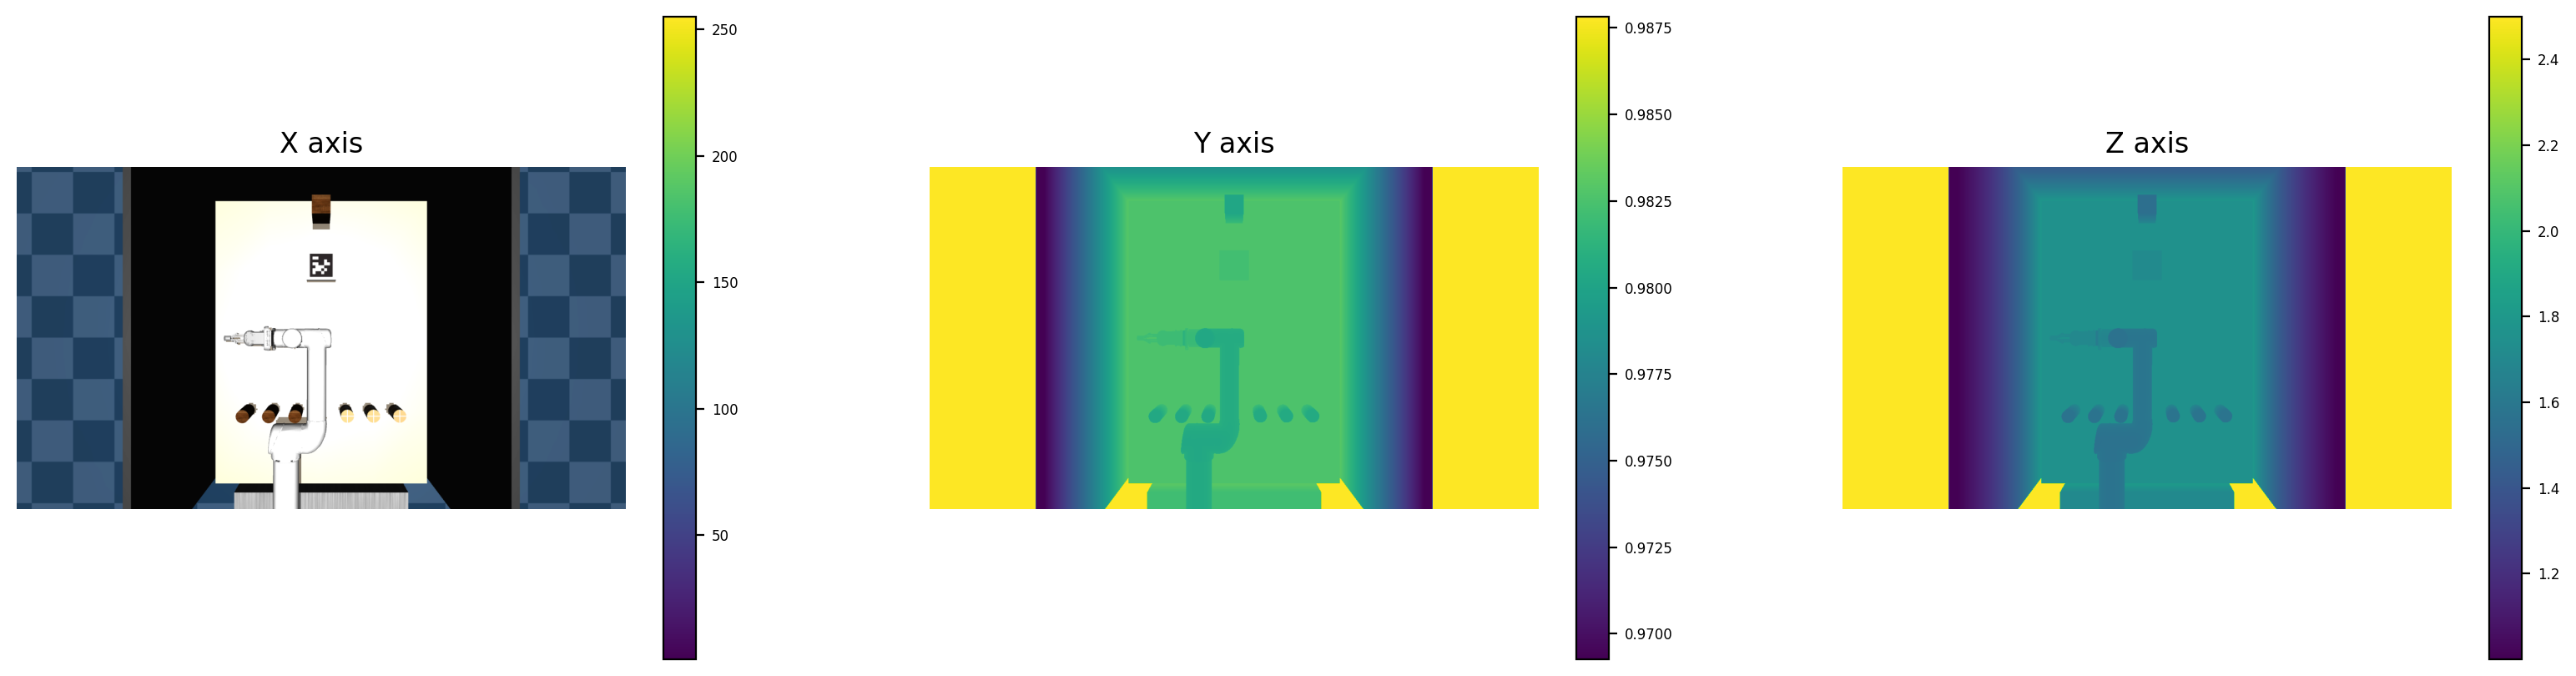

In [3]:
# Up-right table view.
cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                    cam_azimuth   = 0,        # Z-axis: Yaw
                    cam_elevation = -90,      # X-axis: Roll                        
                    cam_lookat    = [1.0, 0.0, 2.5])  # arbitrary offset on camera.

# update object, robot configurations
env.forward(INCREASE_TICK=False)

for _ in range(2):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
    img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=True, camera_name="track")
    img_real = np.array(env.depth2meters(img_depth))

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(img); plt.axis('off')
plt.title("X axis")
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(img_depth); plt.axis('off')
plt.title("Y axis")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(img_real); plt.axis('off')
plt.title("Z axis")
plt.colorbar()
plt.show()

In [4]:
print(env.render_width)
print(env.render_height)

1280
720


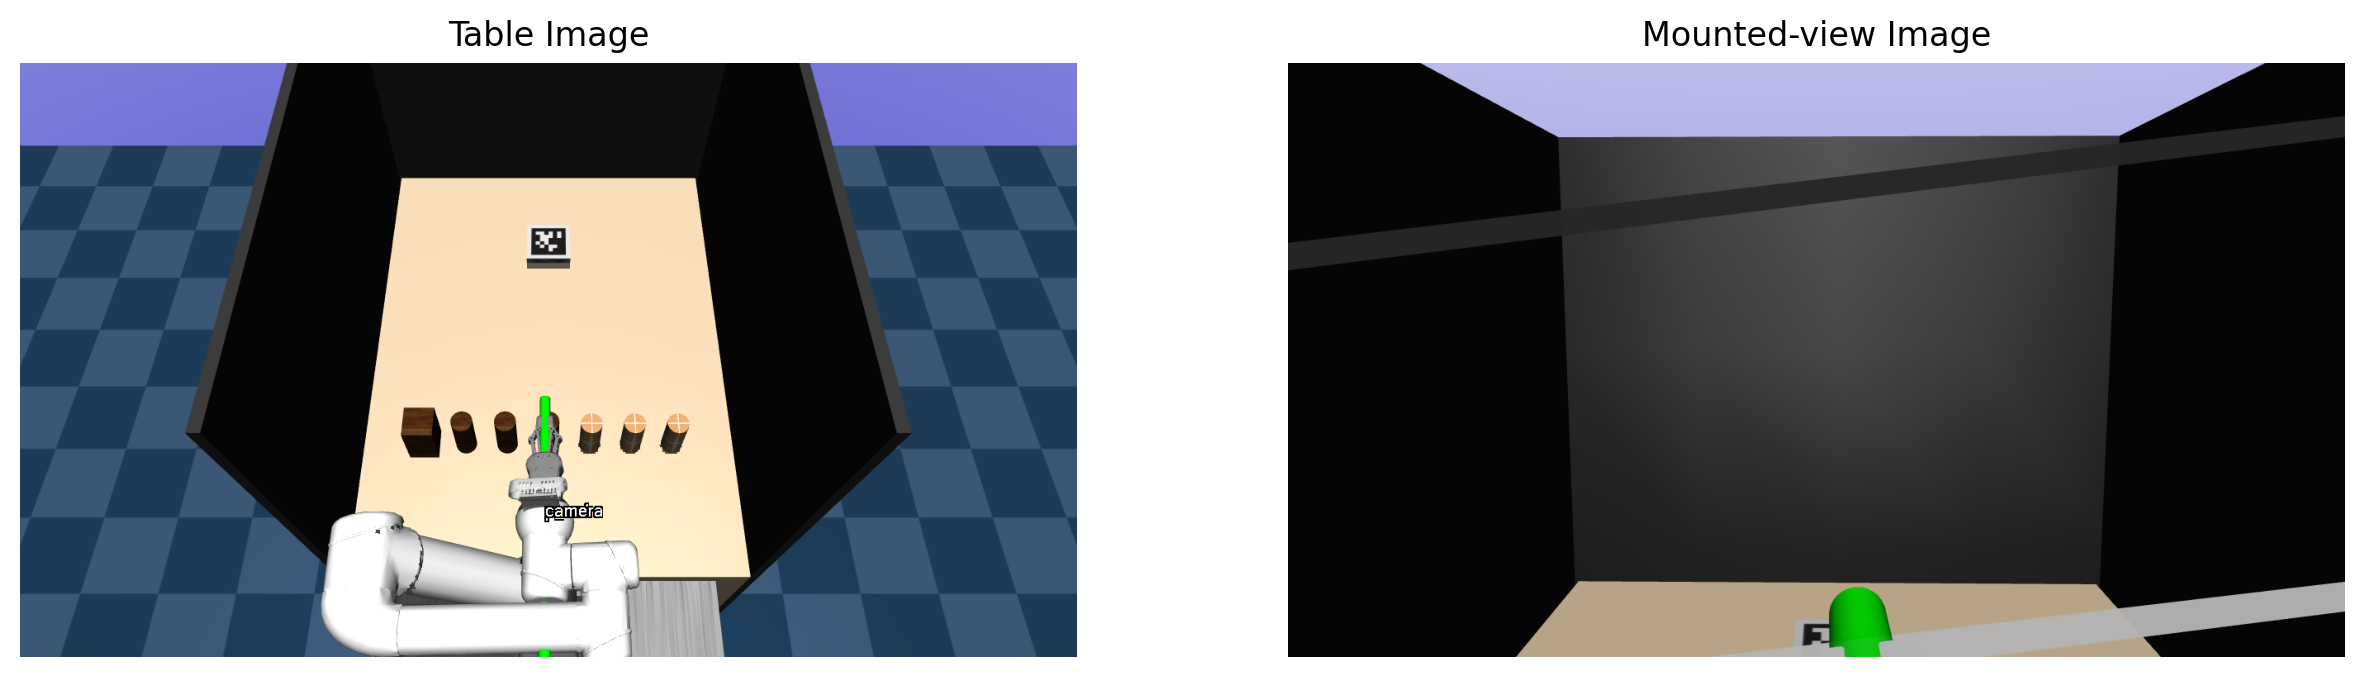

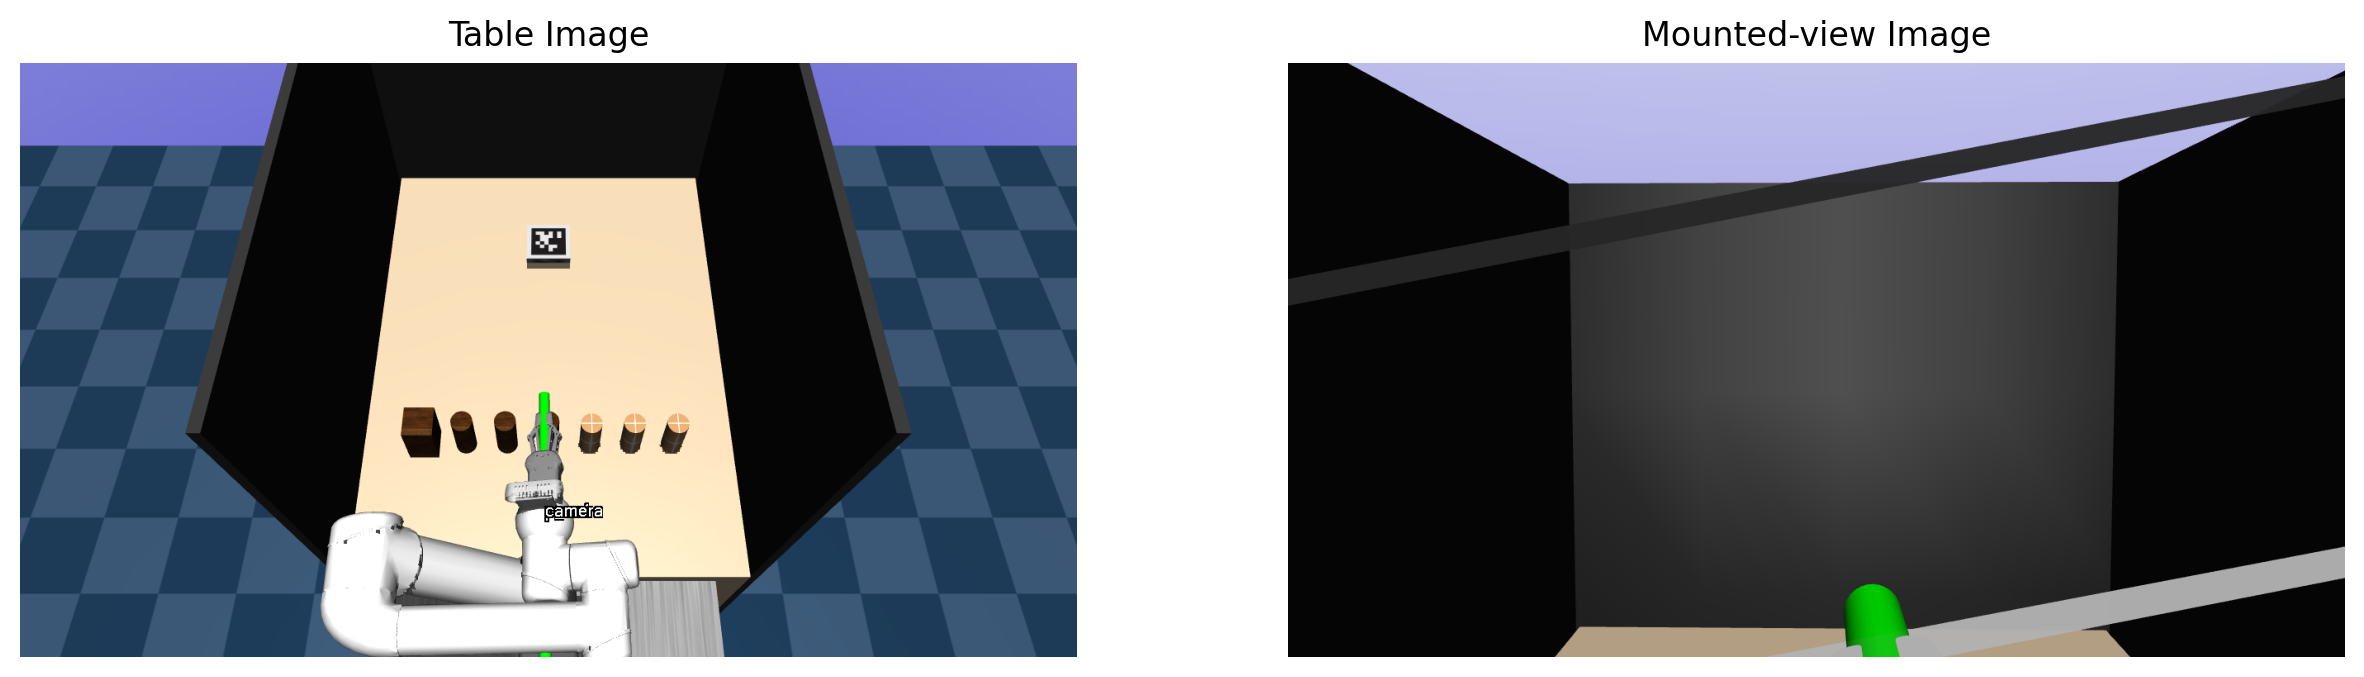

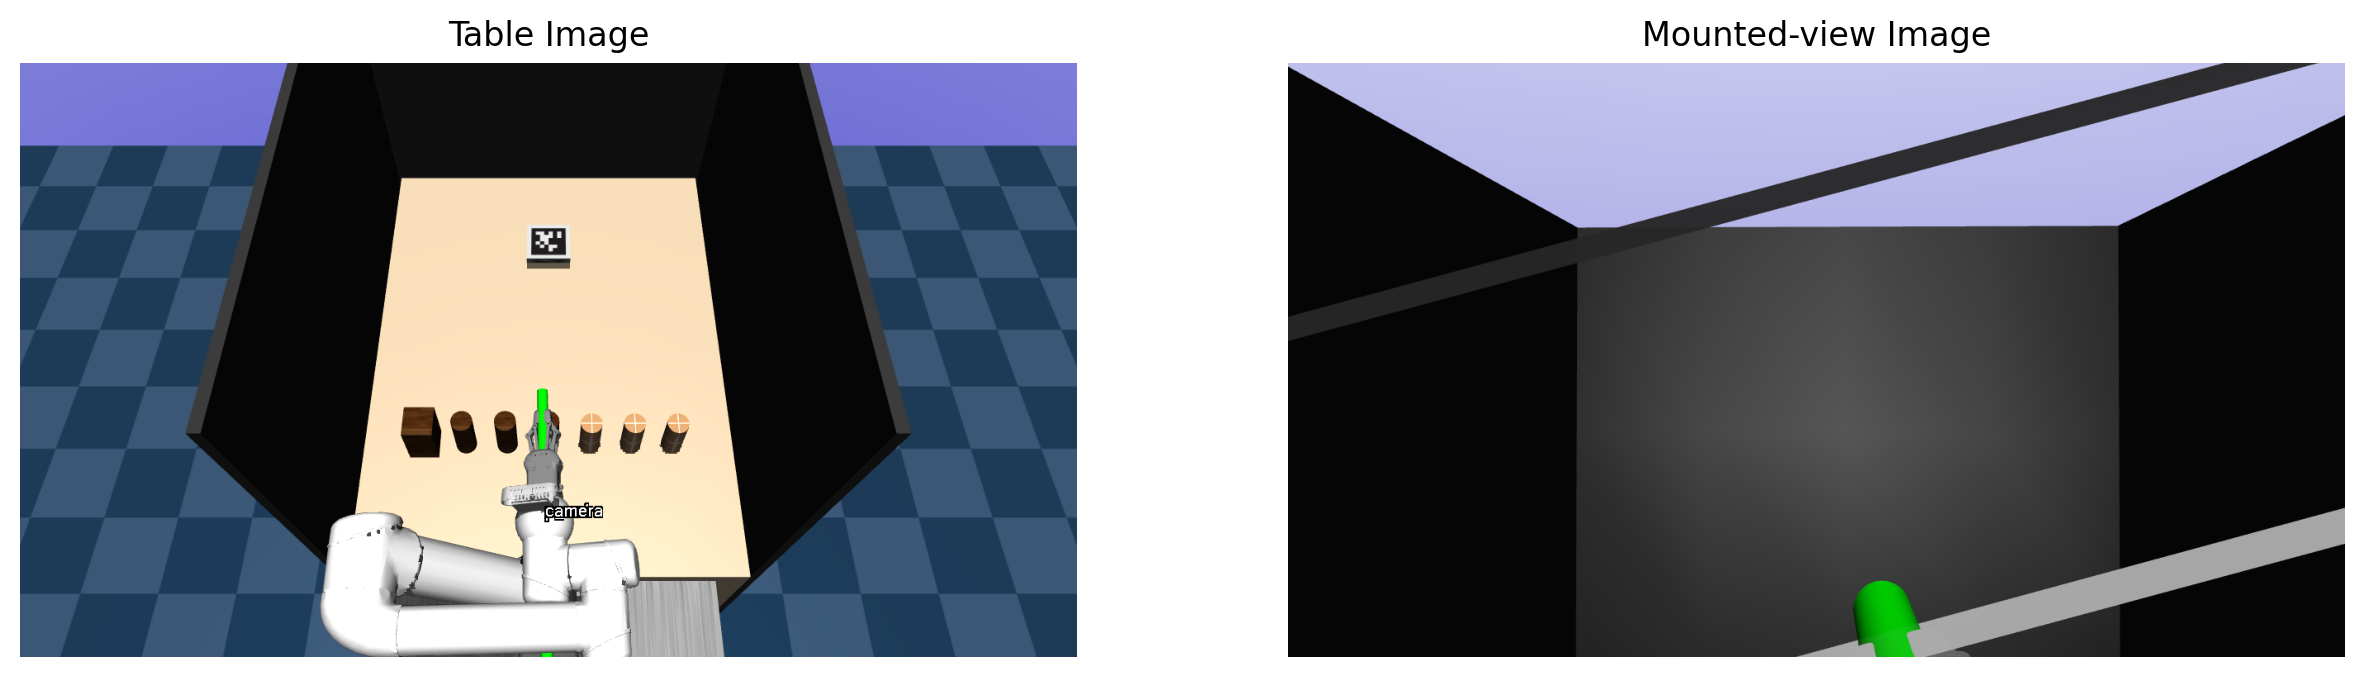

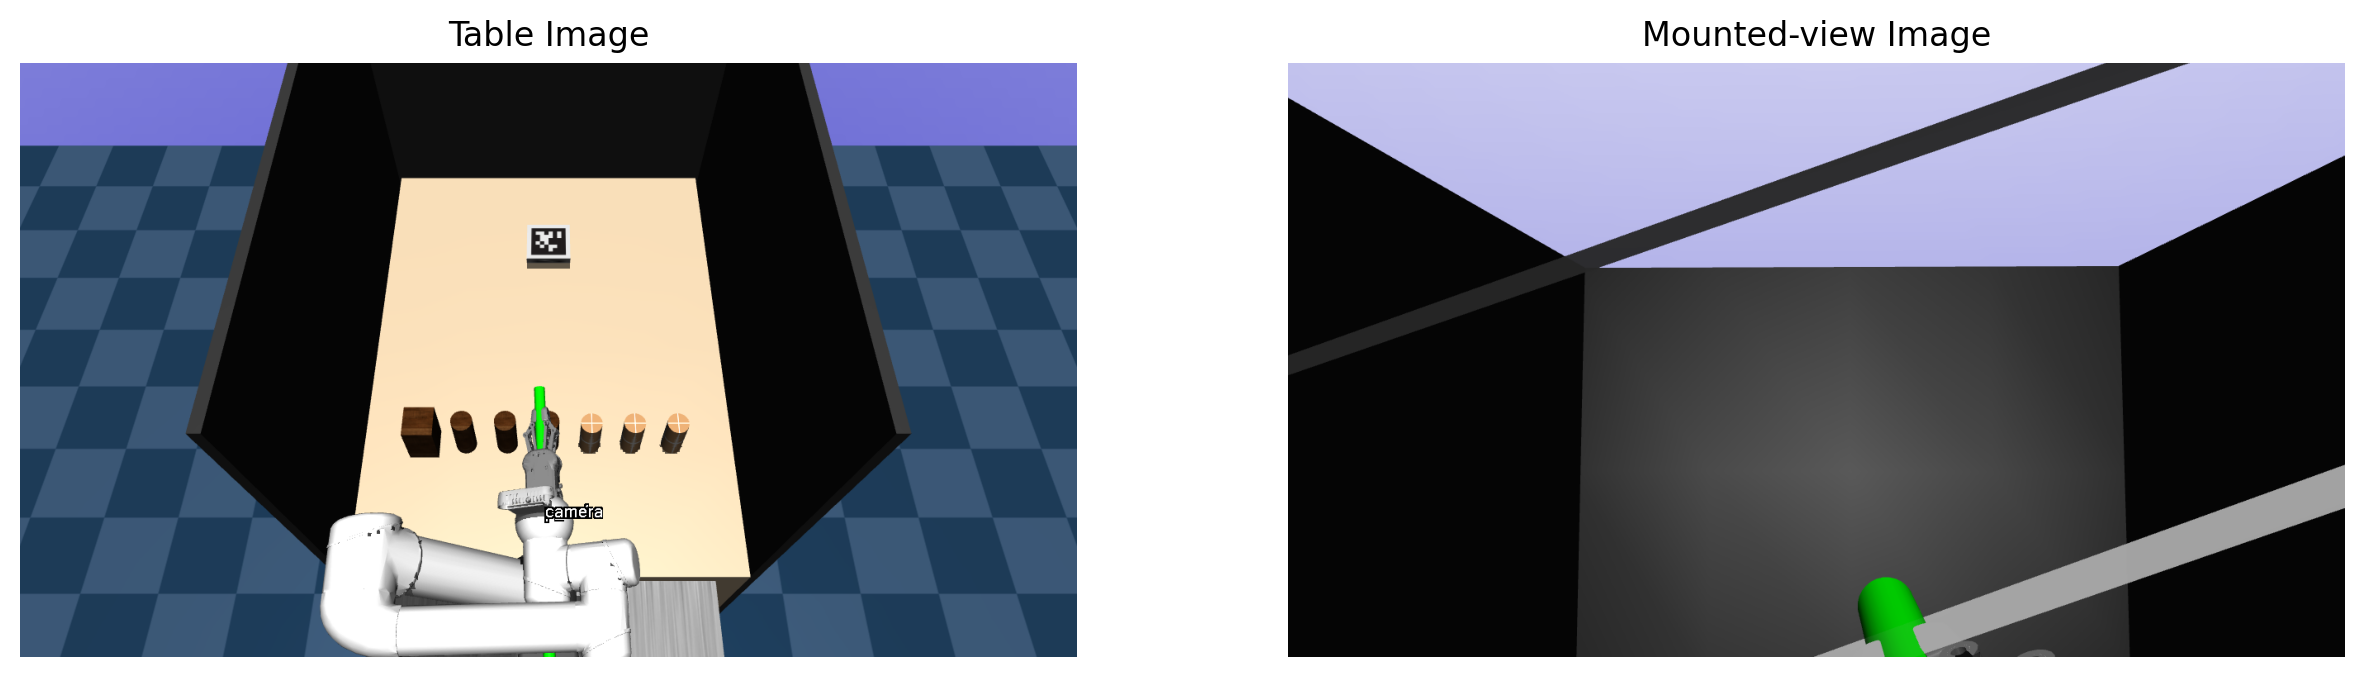

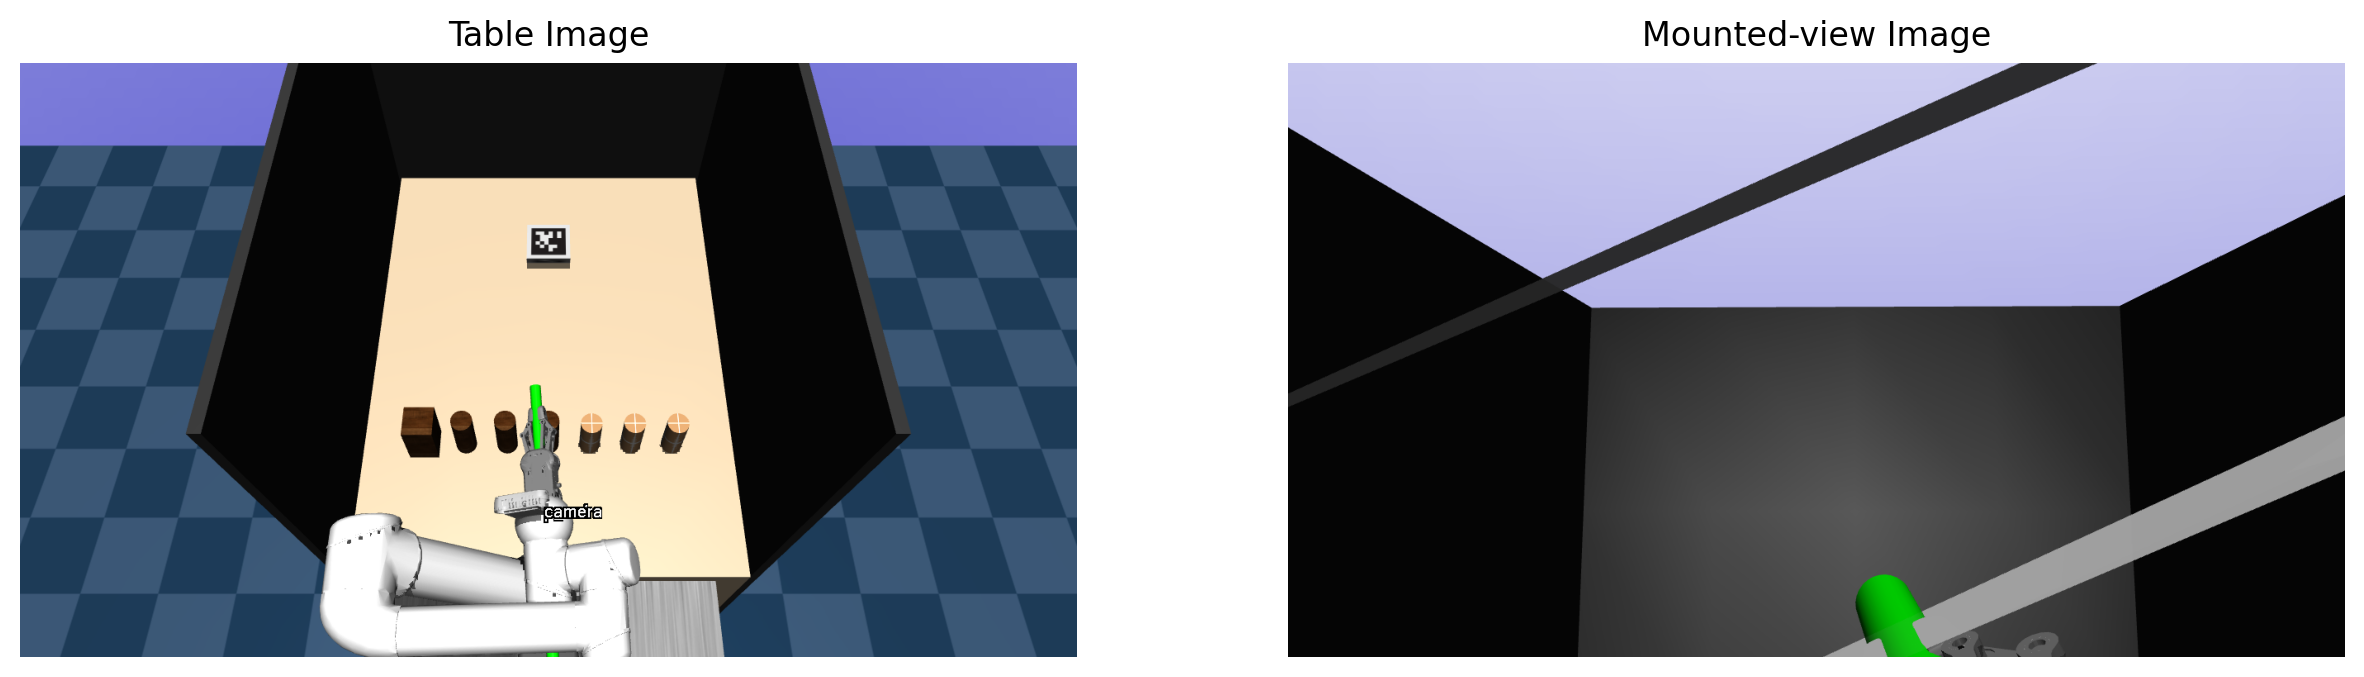

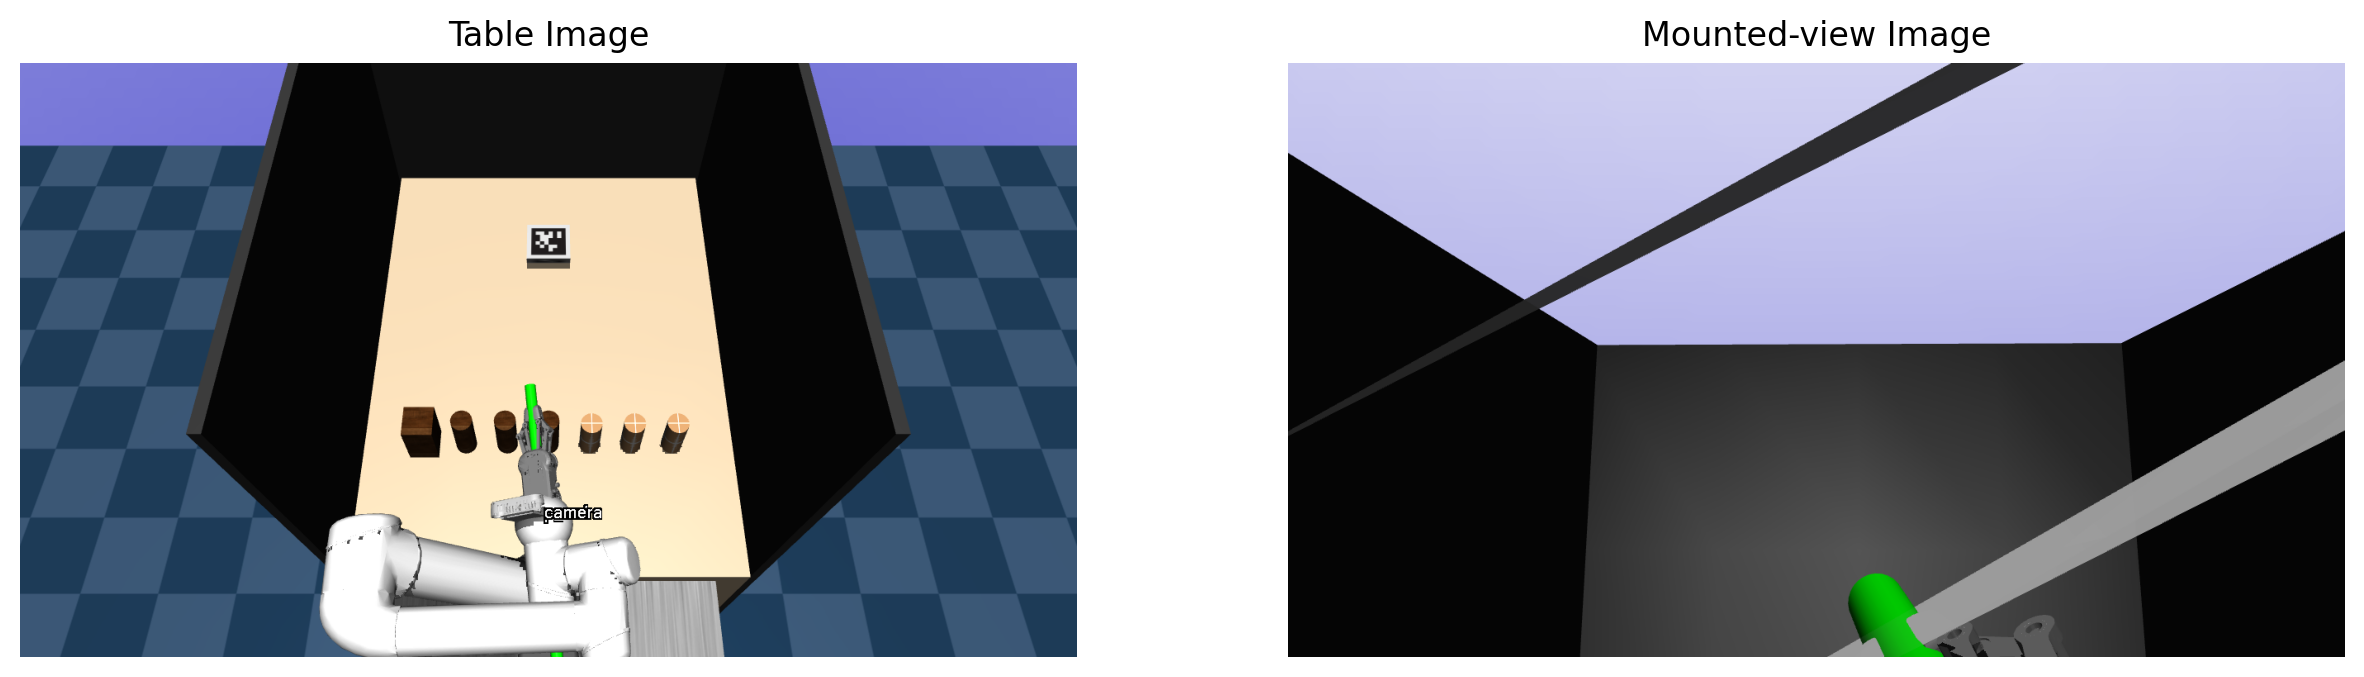

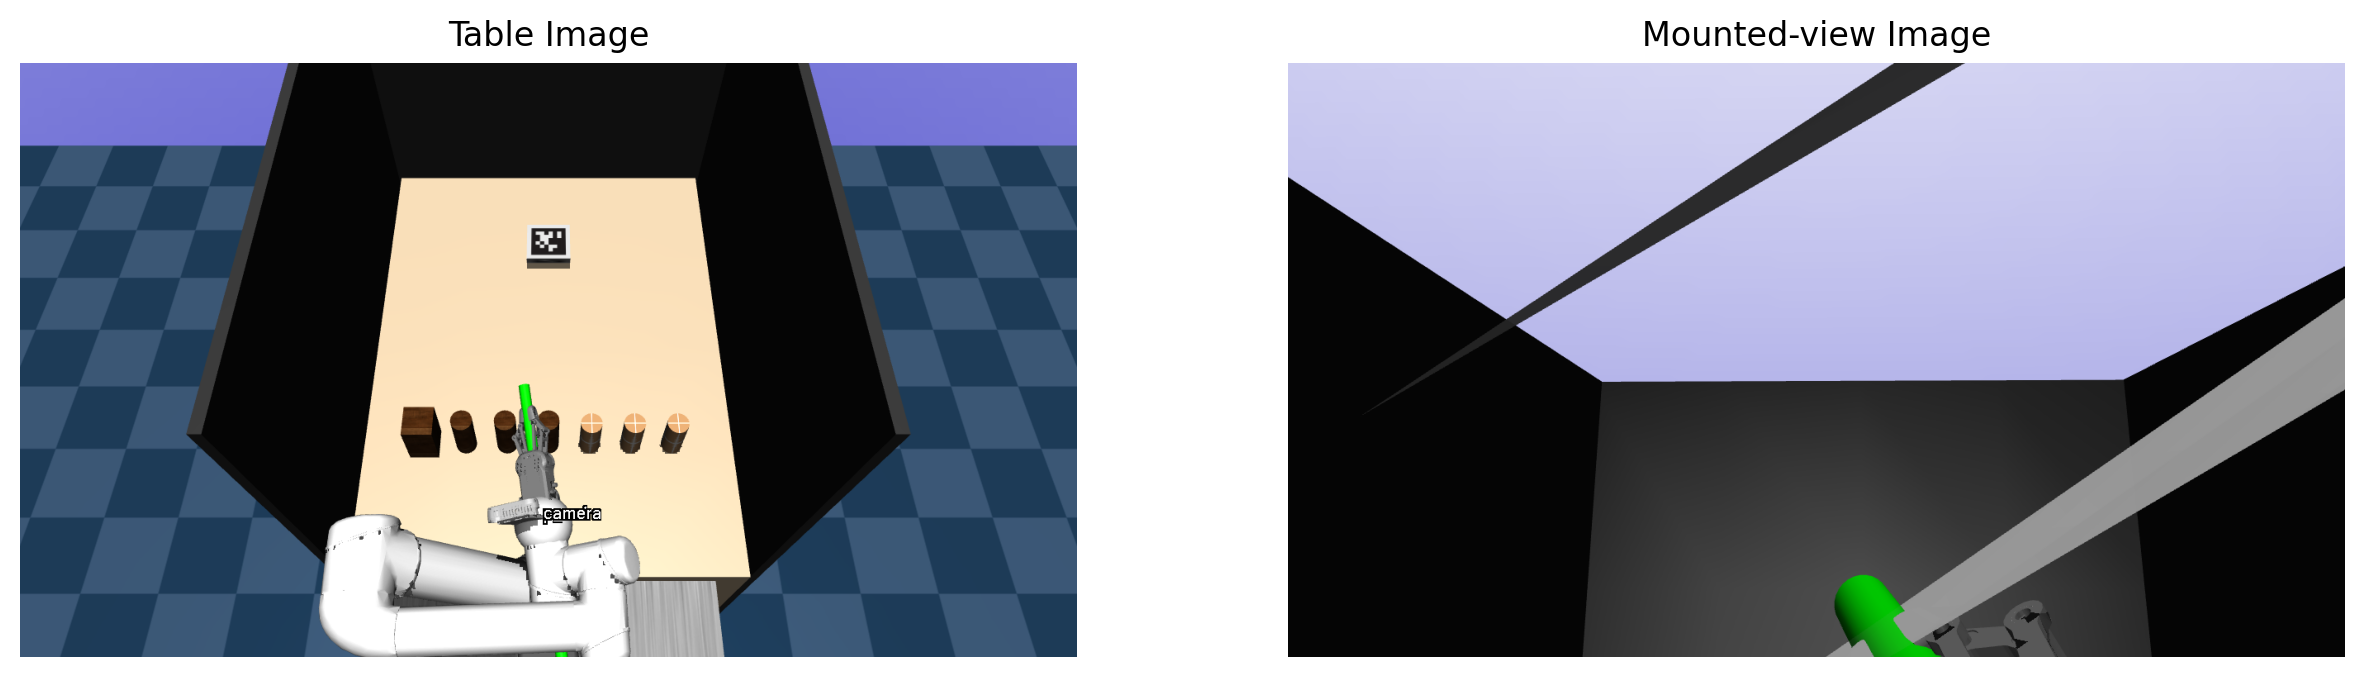

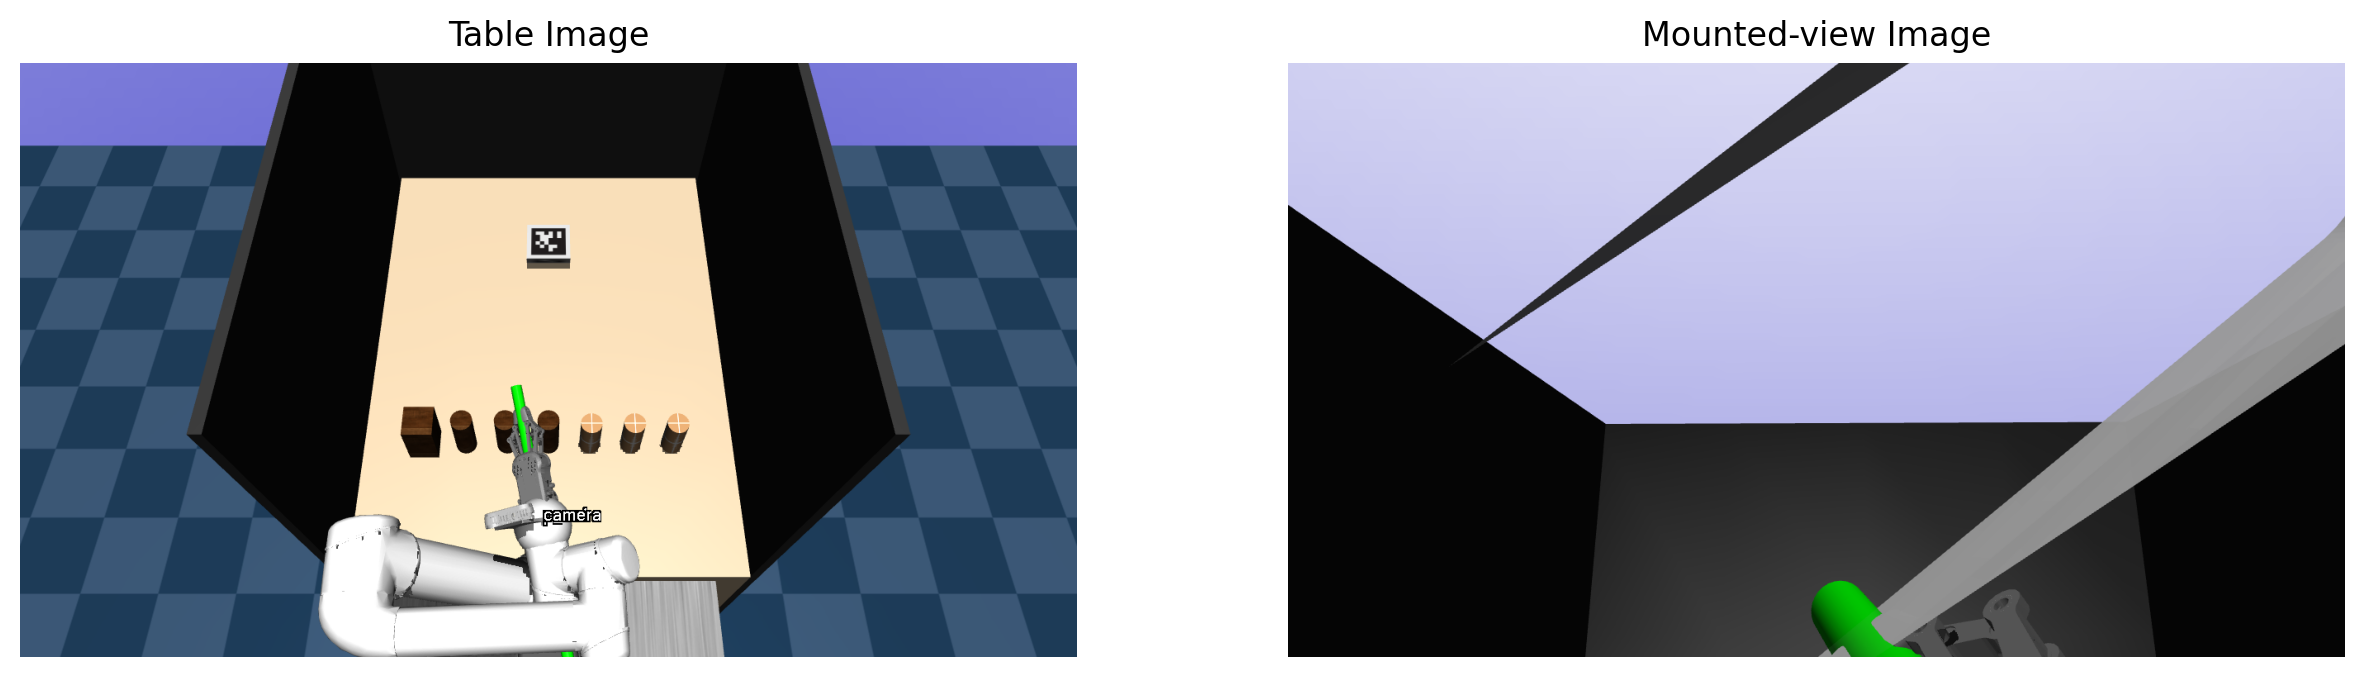

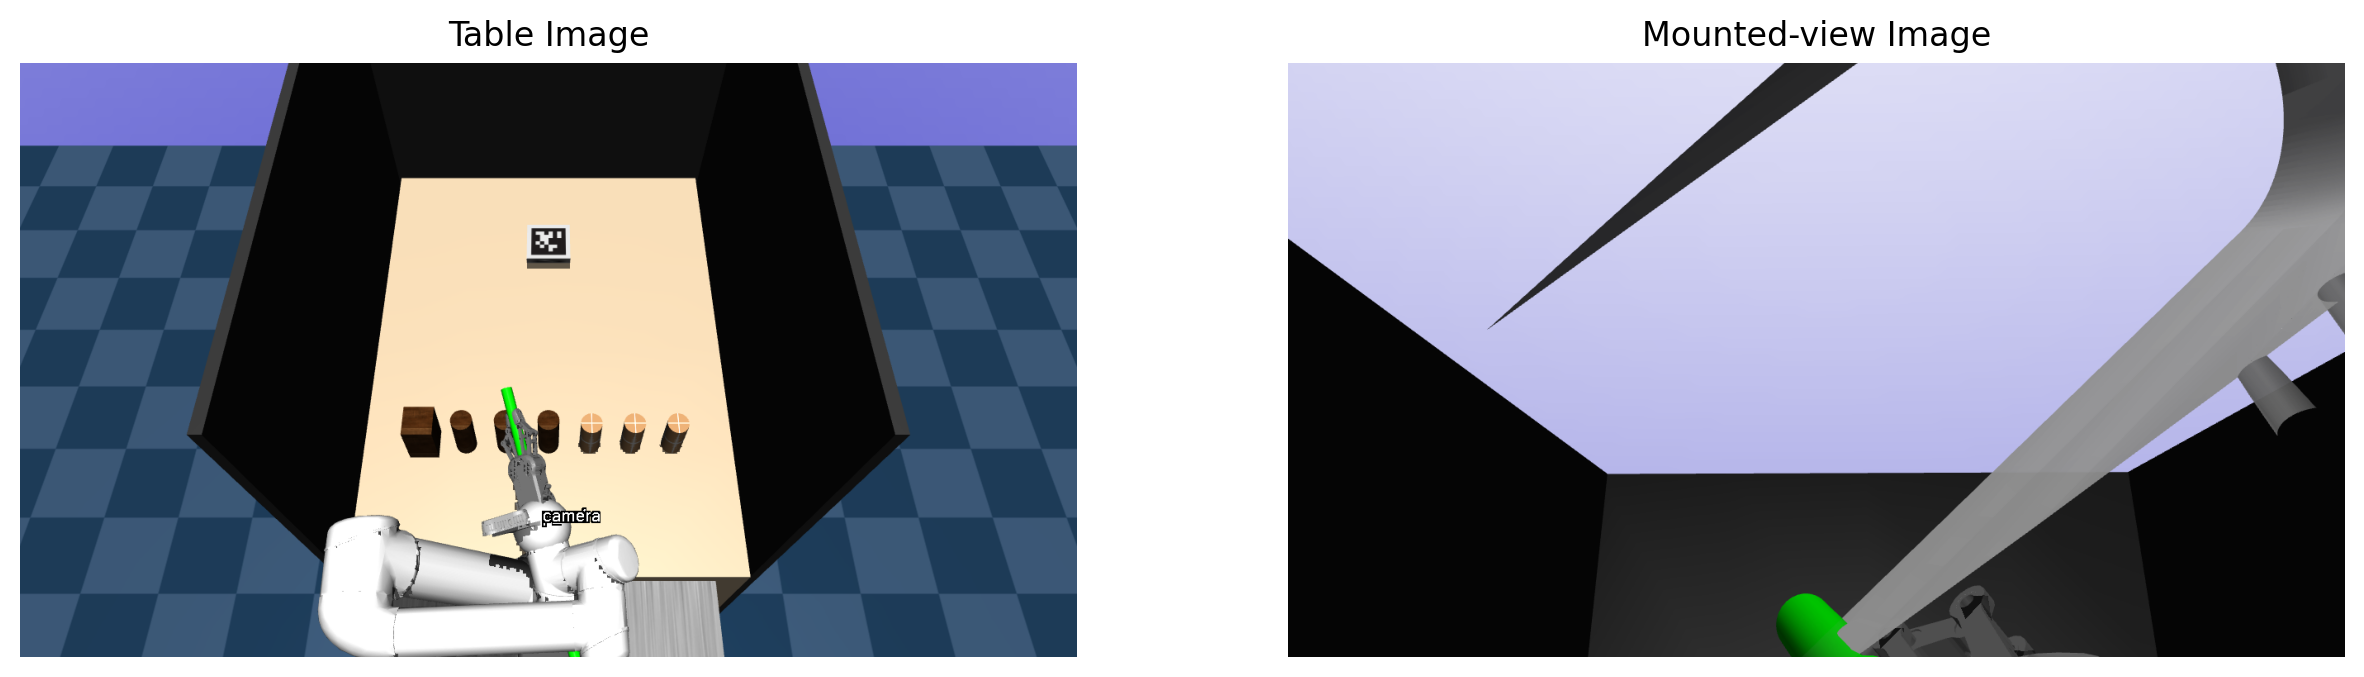

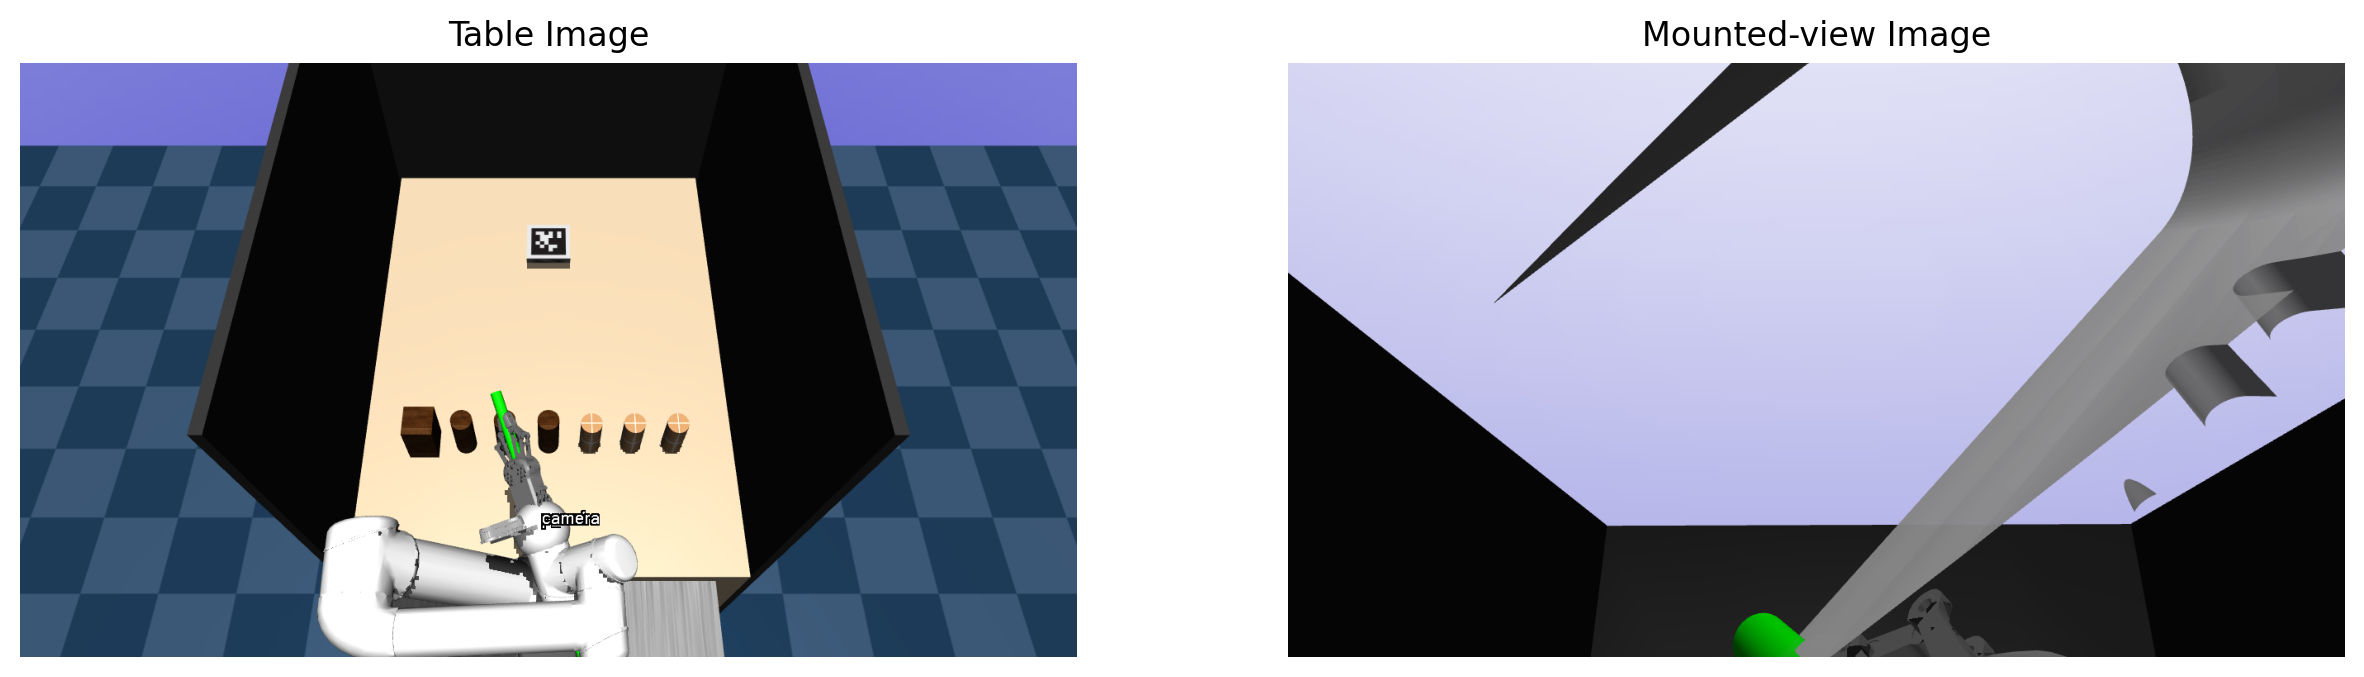

In [15]:
import math

rpy_list = []
r_list = []
eef_list = []

tagpose_list=[]
bs2ee_list=[]

# delete all the markers.
del env.viewer._markers[:]

# Check available objects whose names start with 'obj_'
# Set objects behind of apriltag
obj_names = get_env_obj_names(env,prefix='obj_') # see objects

for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [0.7,-0.3+0.1*obj_idx,0.8]
    obj_quat  = [0,0,0,1]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=None)

# Set AprilTag configurations
april_addr_z = env.sim.model.get_joint_qpos_addr('box_checker_z')
env.sim.data.qpos[april_addr_z] = -math.pi/2

max_tick = 10
env.tick = 0

while env.tick < max_tick:
    # Set Joint Configurations
    init_configurations = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2-0.02*env.tick*math.pi, -0.05-0.02*env.tick*math.pi, -math.pi/2 ]
    set_env_joint_configuration(env, init_configurations, prefix='ur_')

    # update object, robot configurations
    env.step()
    env.forward(INCREASE_TICK=False)

    # Get pose what I want to attach on.
    # Get e.e. pose.
    p_eef = env.get_p_body("ur_rg2_gripper_base_link")
    R_eef = env.get_R_body("ur_rg2_gripper_base_link")
    
    # p_eef = env.get_p_body("ur_rg2_gripper_base_link")
    # R_eef = env.get_R_body("ur_rg2_gripper_base_link")
    R_y = R_eef@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,1,0]))
    R_z = R_eef@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,0,1]))

    axis_len = 0.18

    p_y = p_eef - R_y[:,2]*axis_len/2
    p_z = p_eef + R_z[:,2]*axis_len/2
    # print(f"the p_z is : {p_z}")
    # print(f"the eef is : {p_eef}")

    env.viewer.add_marker(
        pos   = p_eef,
        type  = mujoco_py.generated.const.GEOM_CYLINDER,
        size  = [0.01,0.01,0.5/2],
        mat   = R_z,
        rgba  = [0.0,1.0,0.0,0.9],
        label = 'p_eef'
    )

    env.add_marker_sphere(p=p_eef,radius=0.05,rgba=[1.0,1.0,1.0,1.0],label='camera')

    # Arbitrary offset on camera btw arm.
    # arbi_offset = [0.05, 0, 0.05]
    arbi_offset = [0.0, 0, 0]

    # View Up-right the table.
    cam_table = env.set_cam_infos(cam_distance  = 1.0,
                        cam_azimuth   = 0,   # Z-axis: Yaw
                        cam_elevation = -60,      # X-axis: Roll                        
                        cam_lookat    = [0.5, 0, 1.5])  # arbitrary offset on camera.

    for _ in range(5):
        img_table = env.render_scene(mode='rgb_array', cam_infos=cam_table, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(img_table); plt.axis('off')
    plt.title("Table Image")
    
    R_eef_rpy = r2rpy(R_eef, unit='deg')

    # Follow Robot E.E.
    # cam_infos = env.set_cam_infos(cam_distance  = 0.1,
    #                     cam_azimuth   = R_z_rpy[2]-90,      # Z-axis: Yaw
    #                     cam_elevation = R_z_rpy[1],         # X-axis: Roll                        
    #                     cam_lookat    = p_eef+arbi_offset)  # arbitrary offset on camera.
    # Follow Robot E.E.
    cam_infos = env.set_cam_infos(cam_distance  = -0.0,
                        cam_azimuth   = R_eef_rpy[2]+90,      # Z-axis: Yaw
                        cam_elevation = R_eef_rpy[0]+90,         # X-axis: Roll                        
                        cam_lookat    = p_y)  # arbitrary offset on camera.

    # update object, robot configurations
    env.forward(INCREASE_TICK=False)

    for _ in range(2):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
        img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=True, camera_name="track")
        img_real = np.array(env.depth2meters(img_depth))

    plt.subplot(1,2,2)
    plt.imshow(img); plt.axis('off')
    plt.title("Mounted-view Image")
    plt.show()

    T_april = get_apriltag_pose(env, img, img_real)
    bs2ee_matrix = get_homogeneous_matrix(env, from_link='ur_base_link', to_link='ur_rg2_gripper_base_link', verbose=False)
    
    tagpose_list.append(T_april)
    bs2ee_list.append(bs2ee_matrix)

    # delete all the markers.
    del env.viewer._markers[:]


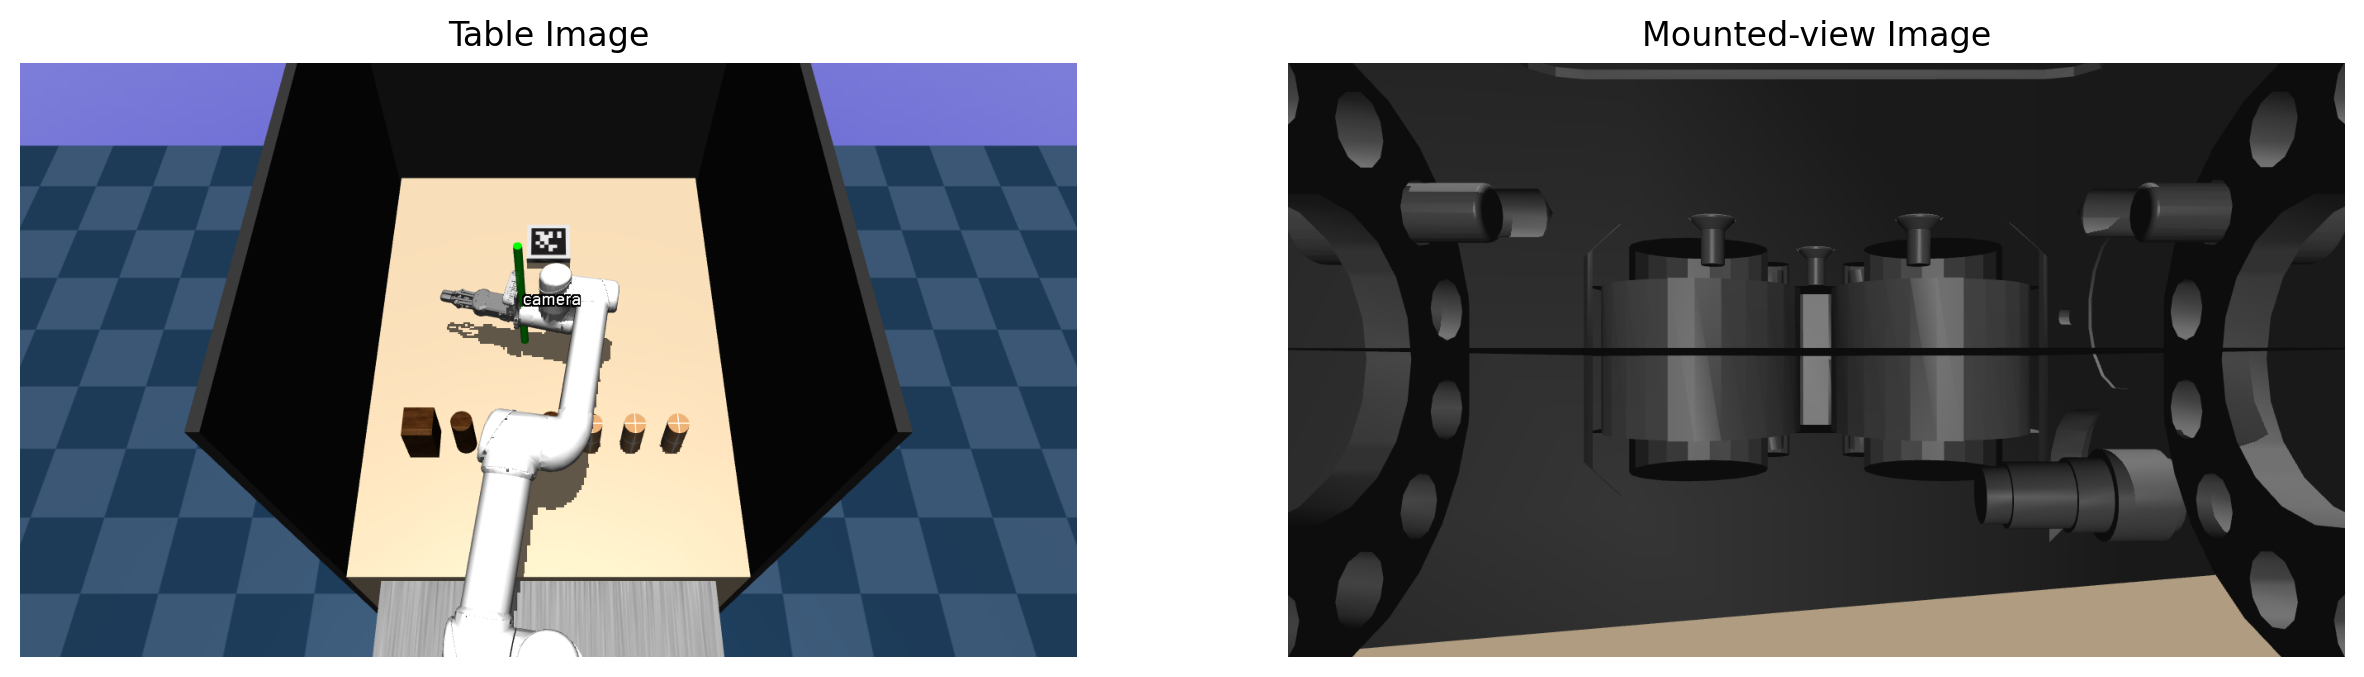

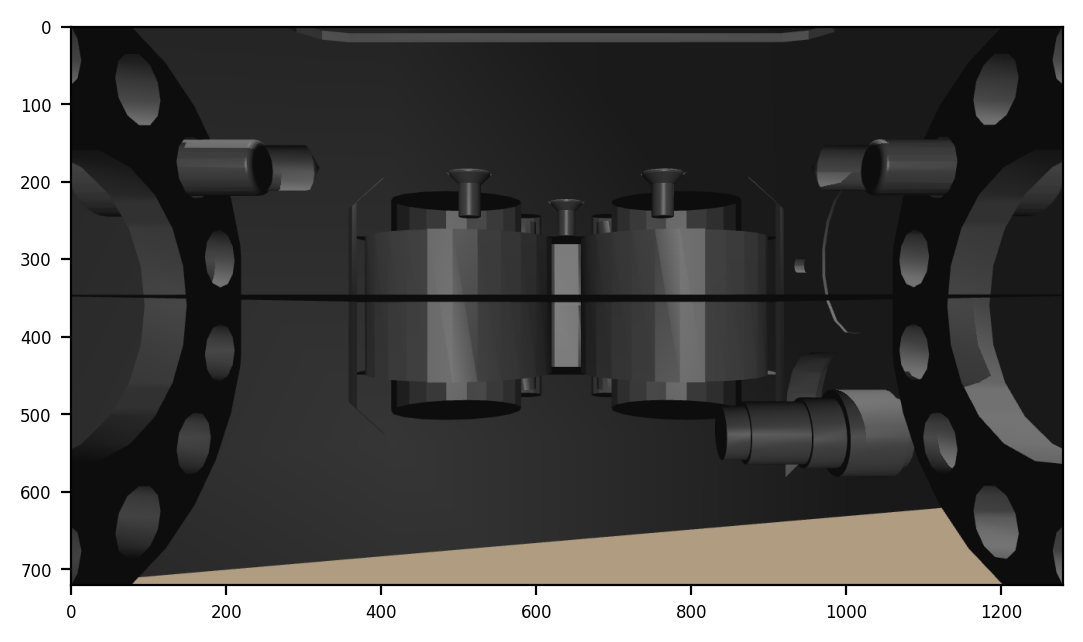

Transformation matrix about 'from link': ur_rg2_gripper_base_link
[[ 9.73e-01 -2.71e-03  2.32e-01  9.97e-01]
 [-2.32e-01 -1.28e-02  9.73e-01  6.43e-02]
 [ 3.50e-04 -1.00e+00 -1.31e-02  8.84e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
Transformation matrix about 'to link': ur_base_link
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'from2to' link: ur_rg2_gripper_base_link -> ur_base_link
[[ 9.73e-01 -2.32e-01  3.50e-04 -7.79e-01]
 [-2.71e-03 -1.28e-02 -1.00e+00  9.69e-02]
 [ 2.32e-01  9.73e-01 -1.31e-02 -2.51e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
data doesn't saved.


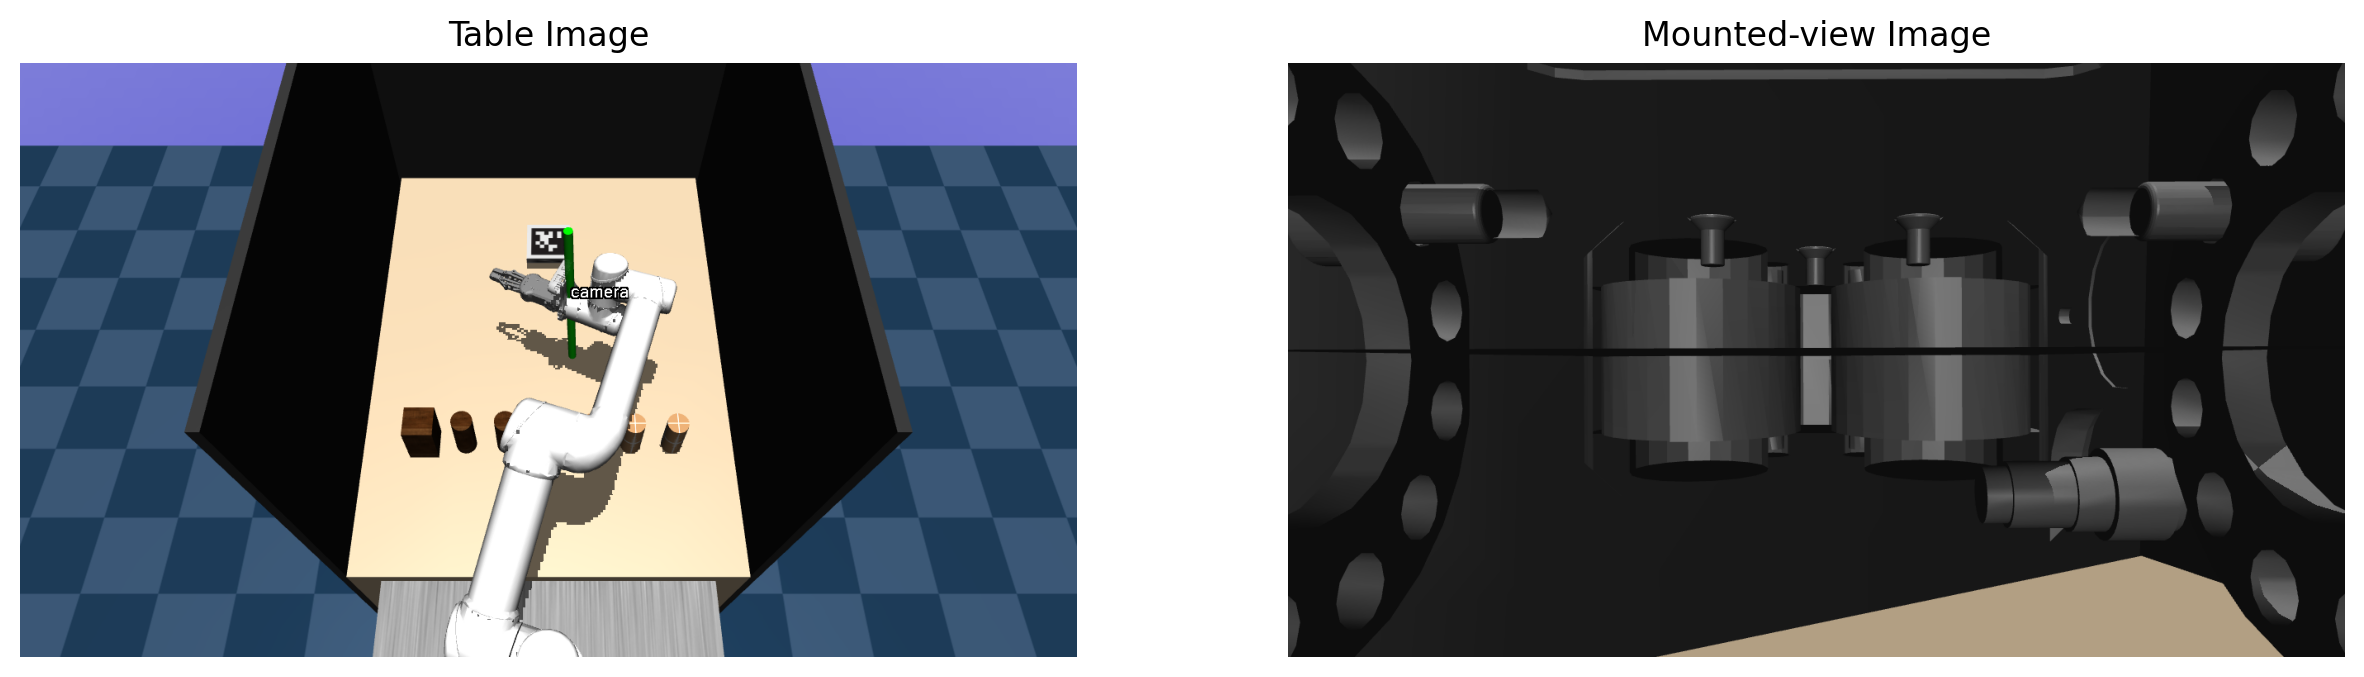

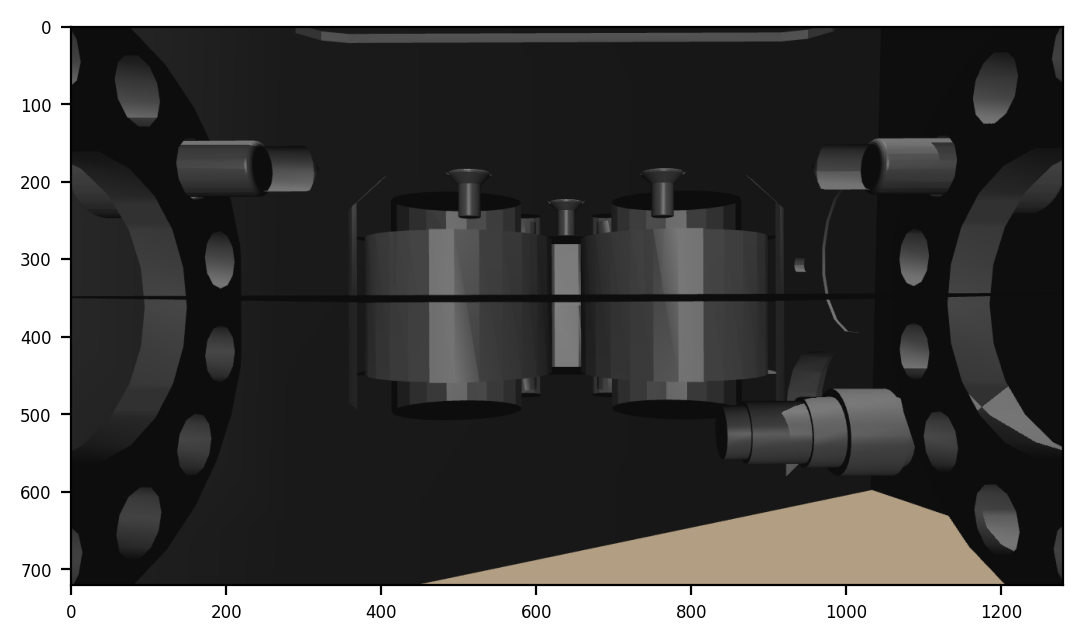

Transformation matrix about 'from link': ur_rg2_gripper_base_link
[[ 0.89 -0.02  0.45  0.96]
 [-0.45 -0.05  0.89 -0.05]
 [ 0.   -1.   -0.05  0.98]
 [ 0.    0.    0.    1.  ]]
Transformation matrix about 'to link': ur_base_link
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'from2to' link: ur_rg2_gripper_base_link -> ur_base_link
[[ 0.89 -0.45  0.   -0.72]
 [-0.02 -0.05 -1.    0.2 ]
 [ 0.45  0.89 -0.05 -0.29]
 [ 0.    0.    0.    1.  ]]
data doesn't saved.


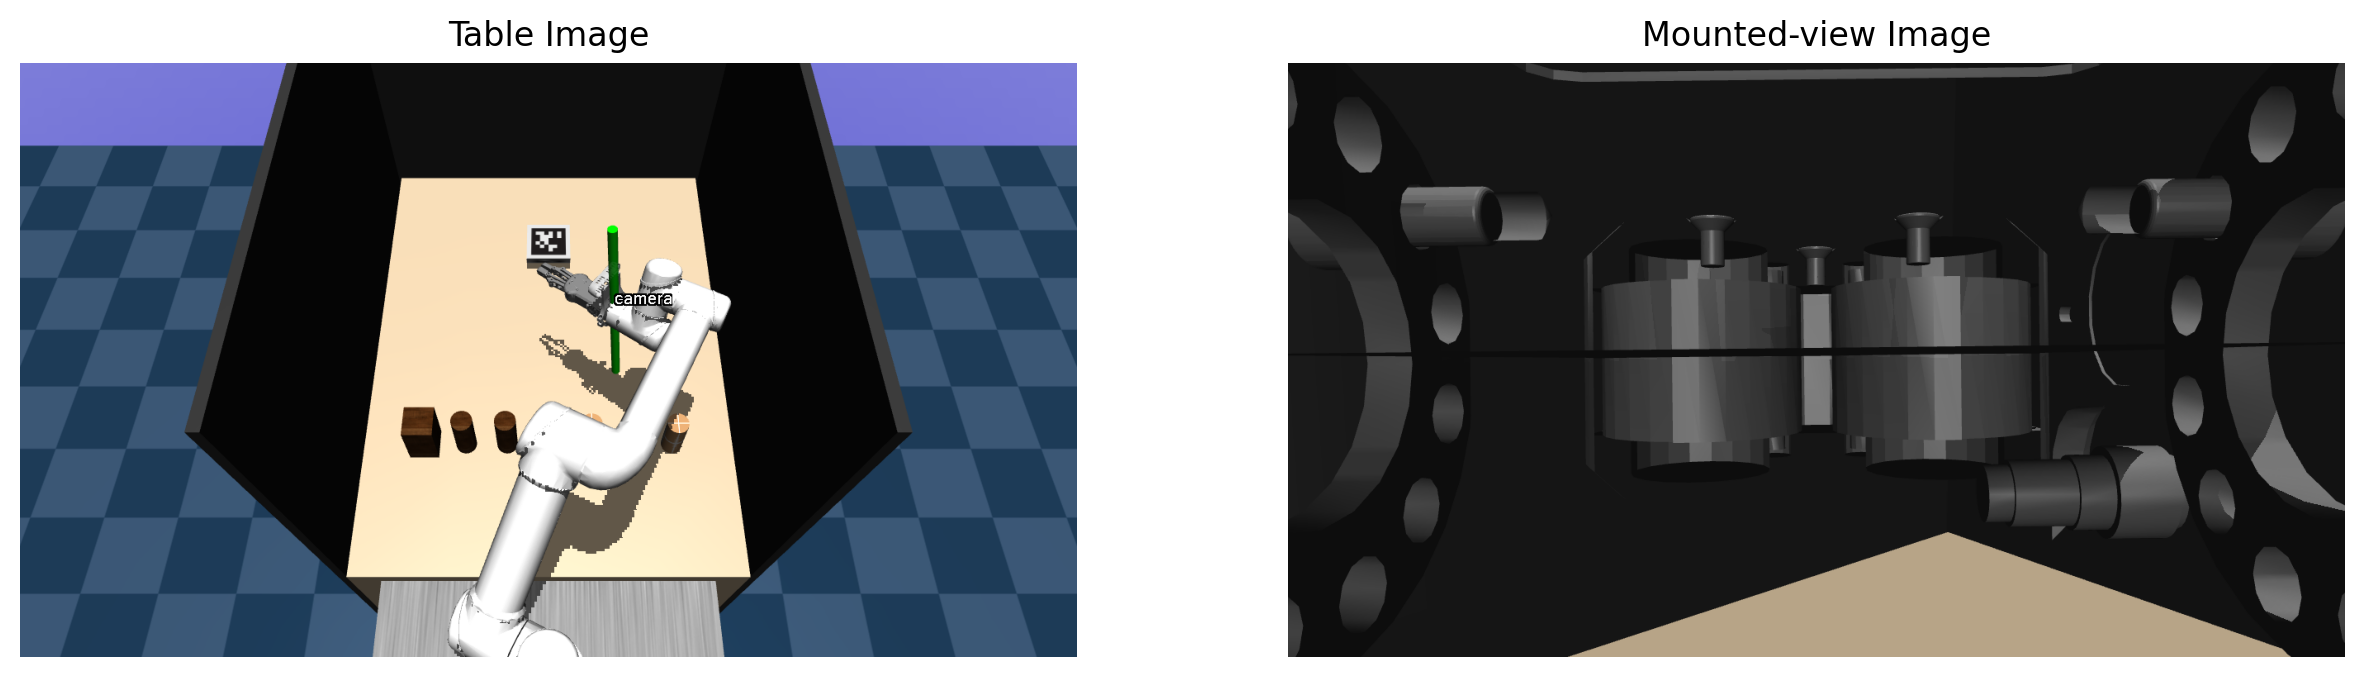

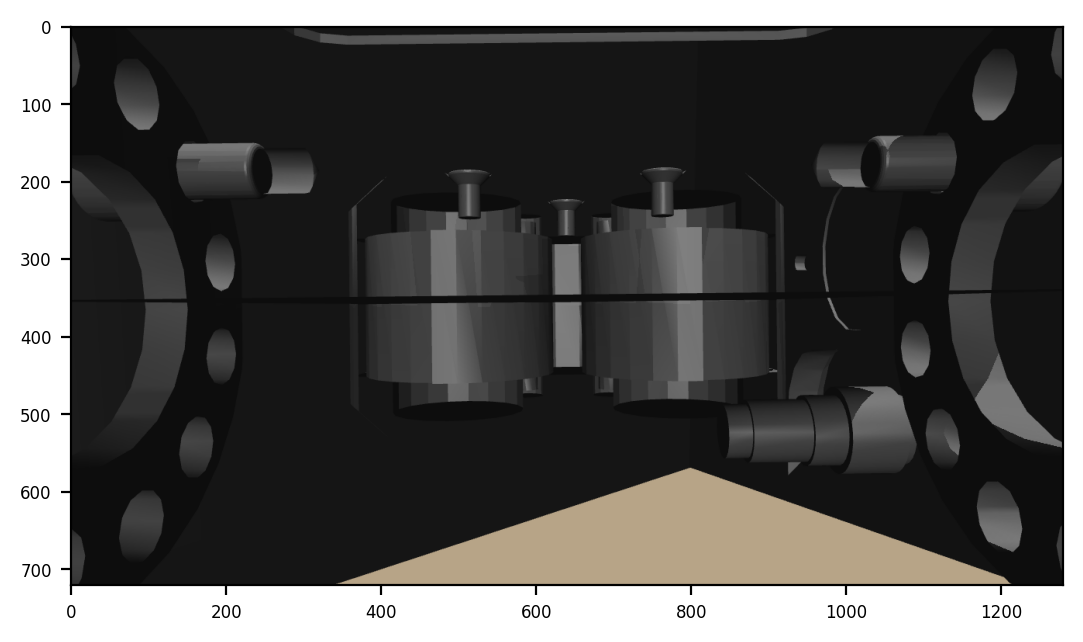

Transformation matrix about 'from link': ur_rg2_gripper_base_link
[[ 0.78 -0.06  0.63  0.88]
 [-0.63 -0.09  0.77 -0.14]
 [ 0.01 -0.99 -0.11  1.06]
 [ 0.    0.    0.    1.  ]]
Transformation matrix about 'to link': ur_base_link
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'from2to' link: ur_rg2_gripper_base_link -> ur_base_link
[[ 0.78 -0.63  0.01 -0.64]
 [-0.06 -0.09 -0.99  0.3 ]
 [ 0.63  0.77 -0.11 -0.3 ]
 [ 0.    0.    0.    1.  ]]
data doesn't saved.


KeyboardInterrupt: 

In [29]:
import math

# delete all the markers.
del env.viewer._markers[:]

# Check available objects whose names start with 'obj_'
# Set objects behind of apriltag
obj_names = get_env_obj_names(env,prefix='obj_') # see objects

for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [0.7,-0.3+0.1*obj_idx,0.8]
    obj_quat  = [0,0,0,1]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=None)

# Set AprilTag configurations
april_addr_z = env.sim.model.get_joint_qpos_addr('box_checker_z')
env.sim.data.qpos[april_addr_z] = -math.pi/2

file_name = 0
max_tick = 10
env.tick = 0

init_configurations = [0, 0, 0, 0, 0, 0]
set_env_joint_configuration(env, init_configurations, prefix='ur_')

# Extrinsic calbration list
tagpose_list = []
bs2ee_list = []

# update object, robot configurations
env.step()

while env.tick < max_tick:
    # Set Joint Configurations
    init_configurations = [-math.pi/2*0.1*env.tick, -3*math.pi/4*0.1*env.tick, 3*math.pi/4*0.1*env.tick, math.pi/2*0.1*env.tick, math.pi/4*0.1*env.tick, -math.pi/2*0.1*env.tick ]
    set_env_joint_configuration(env, init_configurations, prefix='ur_')

    # update object, robot configurations
    env.step()
    env.forward(INCREASE_TICK=False)
    

    # Get pose what I want to attach on.
    # p_eef = env.get_p_body("ur_rg2_gripper_base_link")
    env.sim_state = env.sim.get_state()
    p_eef = np.array(env.sim.data.body_xpos[env.body_name2idx("ur_rg2_gripper_base_link")])    
    R_eef = env.get_R_body("ur_rg2_gripper_base_link")

    R_y = R_eef@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,1,0]))
    axis_len = 0.17
    p_y = p_eef - R_y[:,2]*axis_len/2

    R_z = R_eef@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,0,1]))

    env.add_marker_sphere(p=p_eef,radius=0.03,rgba=[1.0,1.0,1.0,1.0],label='camera')

    env.viewer.add_marker(
        pos   = p_eef,
        type  = mujoco_py.generated.const.GEOM_CYLINDER,
        size  = [0.01,0.01,0.5/2],
        mat   = R_y,
        rgba  = [0.0,1.0,0.0,0.9],
        label = ''
    )

    R_z_rpy = np.degrees(r2rpy(R_z))
    
    # Arbitrary offset on camera btw arm.
    # arbi_offset = [0.05, 0, 0.10]
    arbi_offset = [0.0, 0.0, 0.0]

    # View Up-right the table.
    cam_table = env.set_cam_infos(cam_distance  = 1.0,
                        cam_azimuth   = 0,   # Z-axis: Yaw
                        cam_elevation = -60,      # X-axis: Roll                        
                        cam_lookat    = [0.5, 0, 1.5])  # arbitrary offset on camera.

    for _ in range(5):
        img_table = env.render_scene(mode='rgb_array', cam_infos=cam_table, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(img_table); plt.axis('off')
    plt.title("Table Image")

    # Follow Robot wrist #3.
    cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                        cam_azimuth   = R_z_rpy[2]-90,        # Z-axis: Yaw
                        cam_elevation = -R_z_rpy[0]+90,      # X-axis: Roll                        
                        cam_lookat    = p_eef)  # arbitrary offset on camera.

    # update object, robot configurations
    env.forward(INCREASE_TICK=False)

    for _ in range(2):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
        img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=True, camera_name="track")
        img_real = np.array(env.depth2meters(img_depth))

    plt.subplot(1,2,2)
    plt.imshow(img); plt.axis('off')
    plt.title("Mounted-view Image")
    plt.show()

    T_april = get_apriltag_pose(env, img, img_real)
    bs2ee_matrix = get_homogeneous_matrix(env, from_link='ur_base_link', to_link='ur_rg2_gripper_base_link', verbose=False)
    
    tagpose_list.append(T_april)
    bs2ee_list.append(bs2ee_matrix)
    
    file_name += 1
    get_calibration_data(env, img, img_depth, from_link='ur_rg2_gripper_base_link', to_link='ur_base_link', file_name=file_name, verbose=True)
    
    # delete all the markers.
    del env.viewer._markers[:]


In [26]:
def get_calibration_data(env, img, img_depth, from_link='ur_rg2_gripper_base_link', to_link='ur_base_link', file_name=None, verbose=True):
    # Get matrix A.
    # Transformation matrix about 'camera to target'.
    tagpose, img = get_apriltag_pose(env, img, img_depth)

    plt.imshow(img)
    plt.show()

    if tagpose is not None:    
        R_cam2target = tagpose[:3, :3]
        p_cam2target = tagpose[:3, 3]

        # inverse of T_cam2target matrix
        p_target2cam = -np.linalg.inv(R_cam2target) @ p_cam2target
        R_target2cam = np.linalg.inv(R_cam2target)
        T_target2cam = cv2.hconcat((R_target2cam, p_target2cam))      # 3x4
        T_target2cam = np.vstack((T_target2cam, np.array([0,0,0,1])))   # 4x4

    # Get matrix B.
    # Transformation matrix about 'ee to base'.
    T_ee2bs = get_homogeneous_matrix(env, from_link=from_link, to_link=to_link, verbose=True)
    R_ee2bs = T_ee2bs[:3, :3]
    p_ee2bs = T_ee2bs[:3, 3]

    if tagpose is not None and verbose == True:    
        print(T_target2cam)
        print(T_ee2bs)

    if tagpose is not None:
        np.save(f'./data/20230215/R_ee2bs_{file_name}.npy', R_ee2bs)
        np.save(f'./data/20230215/p_ee2bs_{file_name}.npy', p_ee2bs)
        np.save(f'./data/20230215/R_target2cam_{file_name}.npy', R_target2cam)
        np.save(f'./data/20230215/p_target2cam_{file_name}.npy', p_target2cam)
        print("data saved completely.")
    else:
        print("data doesn't saved.")


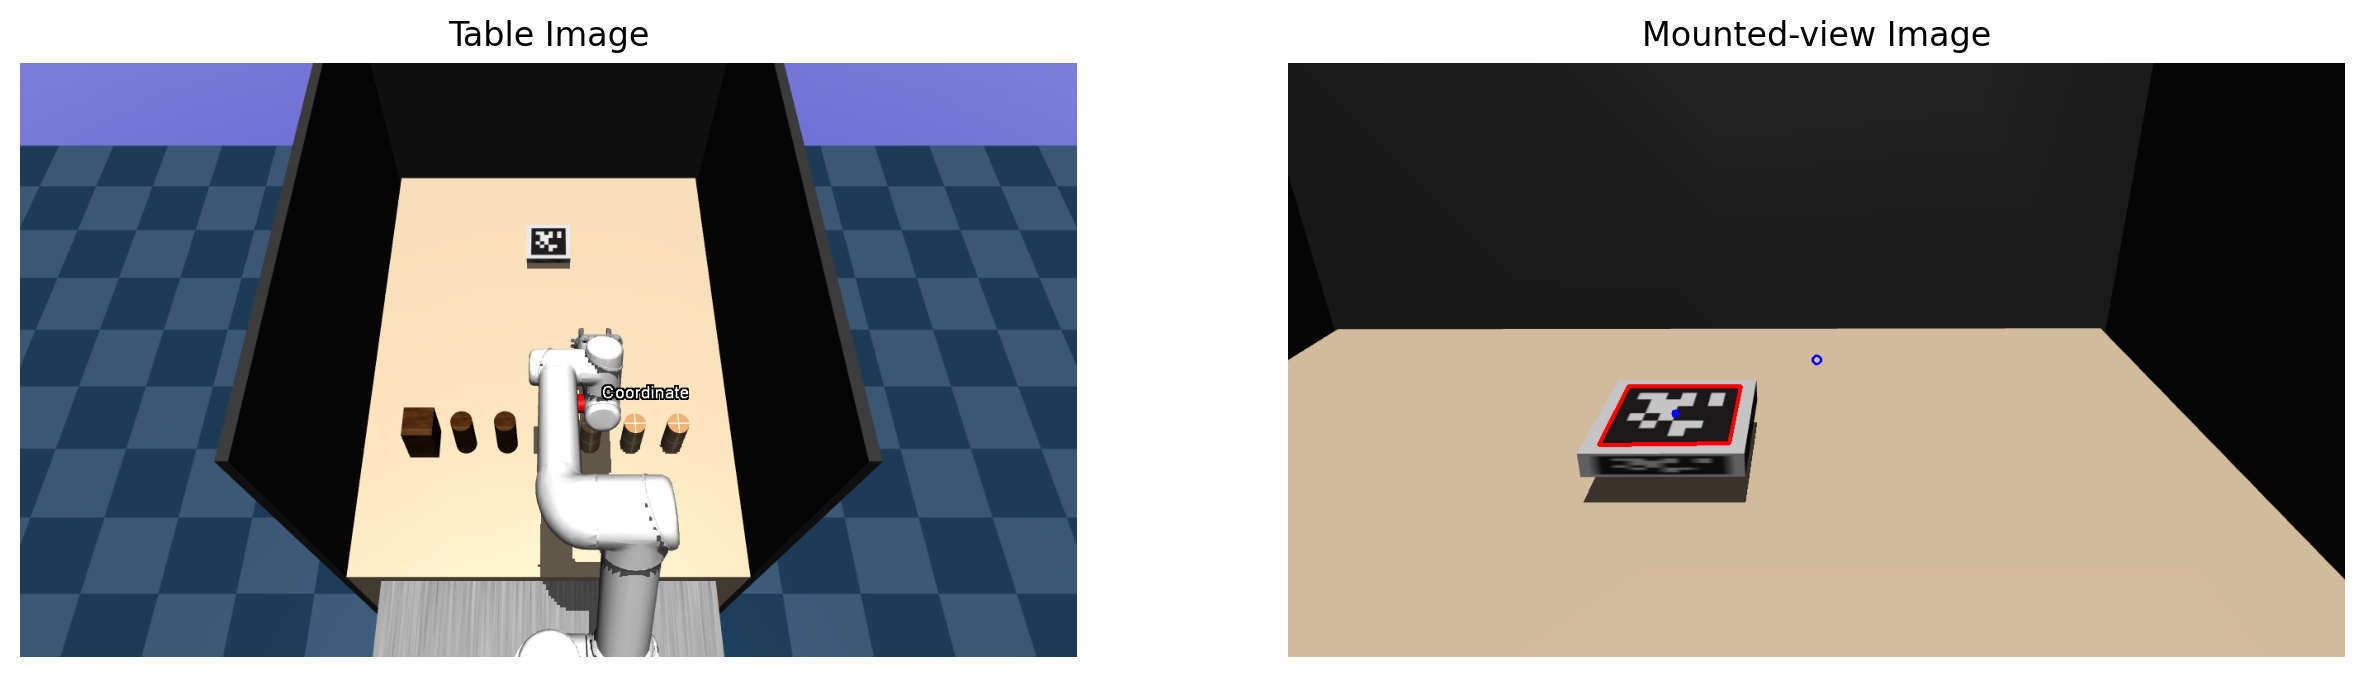

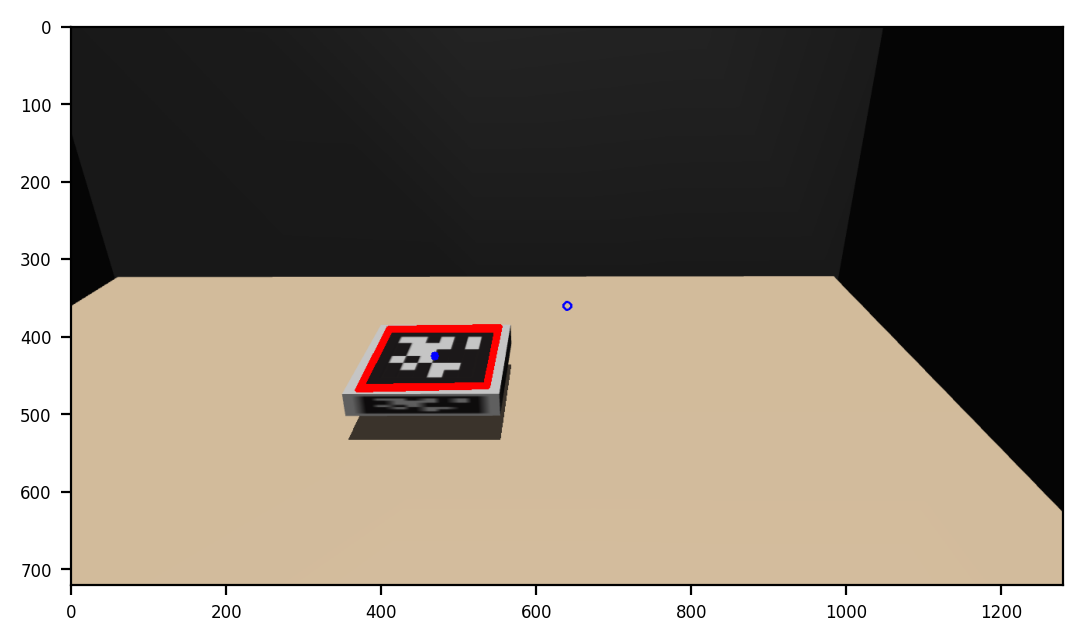

Transformation matrix about 'from link': ur_rg2_gripper_base_link
[[-3.31e-03 -4.14e-01  9.10e-01  7.47e-01]
 [-1.00e+00  1.59e-04 -3.56e-03 -1.12e-01]
 [ 1.33e-03 -9.10e-01 -4.14e-01  9.79e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
Transformation matrix about 'to link': ur_base_link
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'from2to' link: ur_rg2_gripper_base_link -> ur_base_link
[[-3.31e-03 -1.00e+00  1.33e-03 -1.10e-01]
 [-4.14e-01  1.59e-04 -9.10e-01  4.07e-01]
 [ 9.10e-01 -3.56e-03 -4.14e-01 -4.38e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
[[ 1.   -0.02 -0.02  0.05]
 [-0.01  0.44 -0.9   0.47]
 [ 0.02  0.9   0.44 -0.35]
 [ 0.    0.    0.    1.  ]]
[[-3.31e-03 -1.00e+00  1.33e-03 -1.10e-01]
 [-4.14e-01  1.59e-04 -9.10e-01  4.07e-01]
 [ 9.10e-01 -3.56e-03 -4.14e-01 -4.38e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
data saved completely.


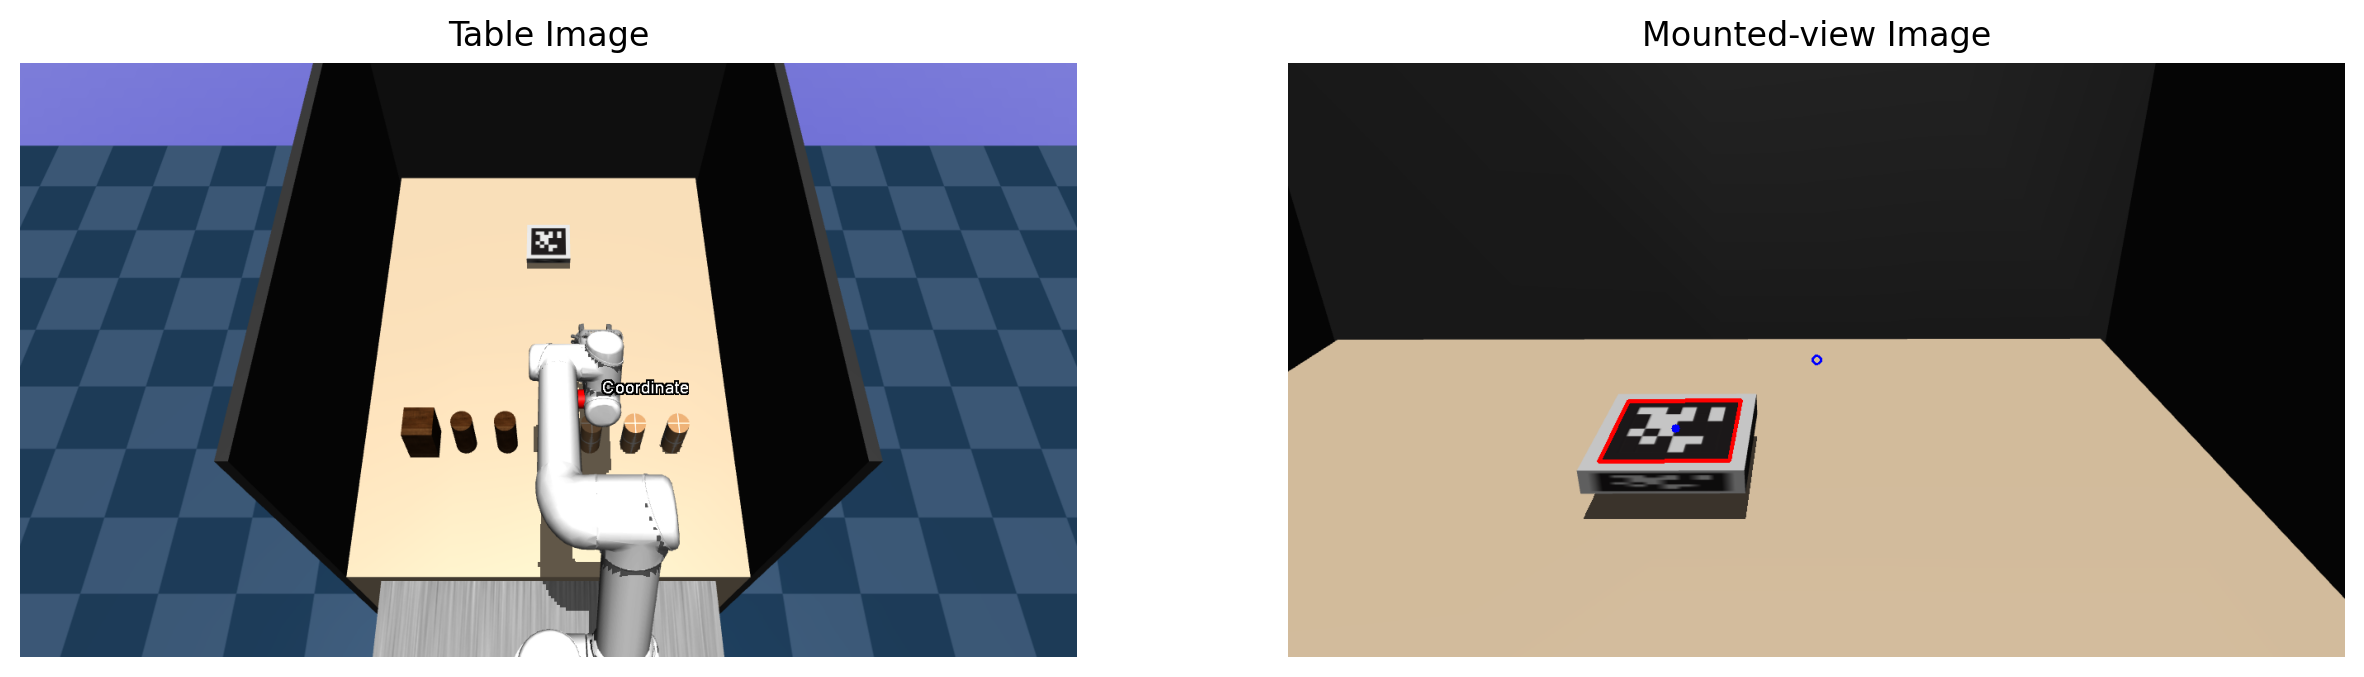

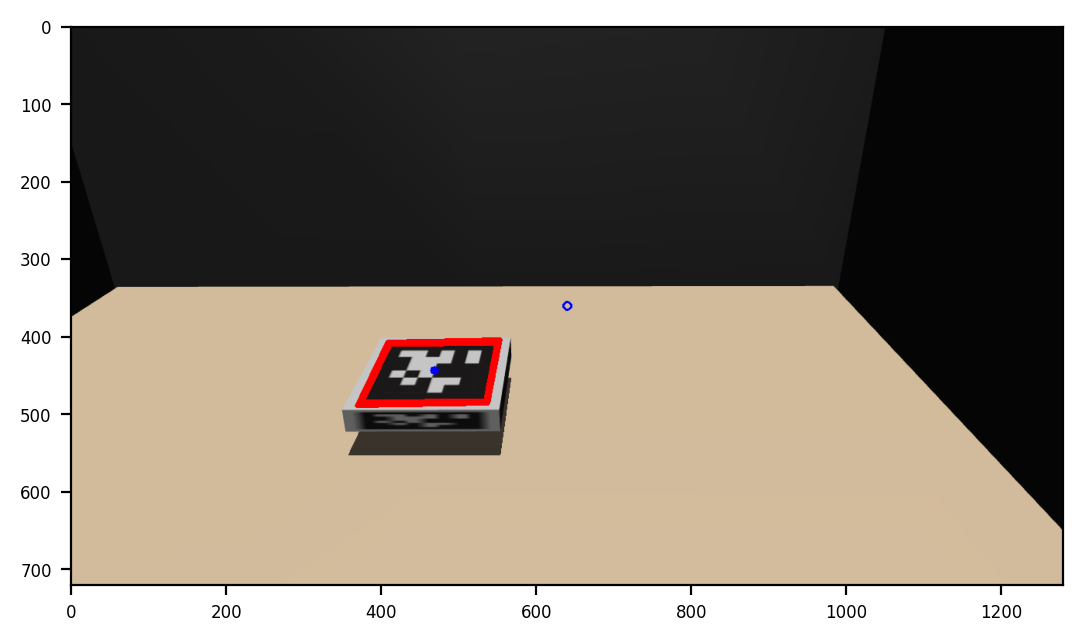

Transformation matrix about 'from link': ur_rg2_gripper_base_link
[[-3.29e-03 -4.14e-01  9.10e-01  7.52e-01]
 [-1.00e+00  1.58e-04 -3.55e-03 -1.12e-01]
 [ 1.32e-03 -9.10e-01 -4.14e-01  9.91e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
Transformation matrix about 'to link': ur_base_link
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'from2to' link: ur_rg2_gripper_base_link -> ur_base_link
[[-3.29e-03 -1.00e+00  1.32e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  4.19e-01]
 [ 9.10e-01 -3.55e-03 -4.14e-01 -4.38e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
[[ 1.00e+00 -1.59e-02 -8.86e-03  6.18e-02]
 [-9.77e-04  4.39e-01 -8.98e-01  4.67e-01]
 [ 1.82e-02  8.98e-01  4.39e-01 -3.54e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
[[-3.29e-03 -1.00e+00  1.32e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  4.19e-01]
 [ 9.10e-01 -3.55e-03 -4.14e-01 -4.38e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
data saved c

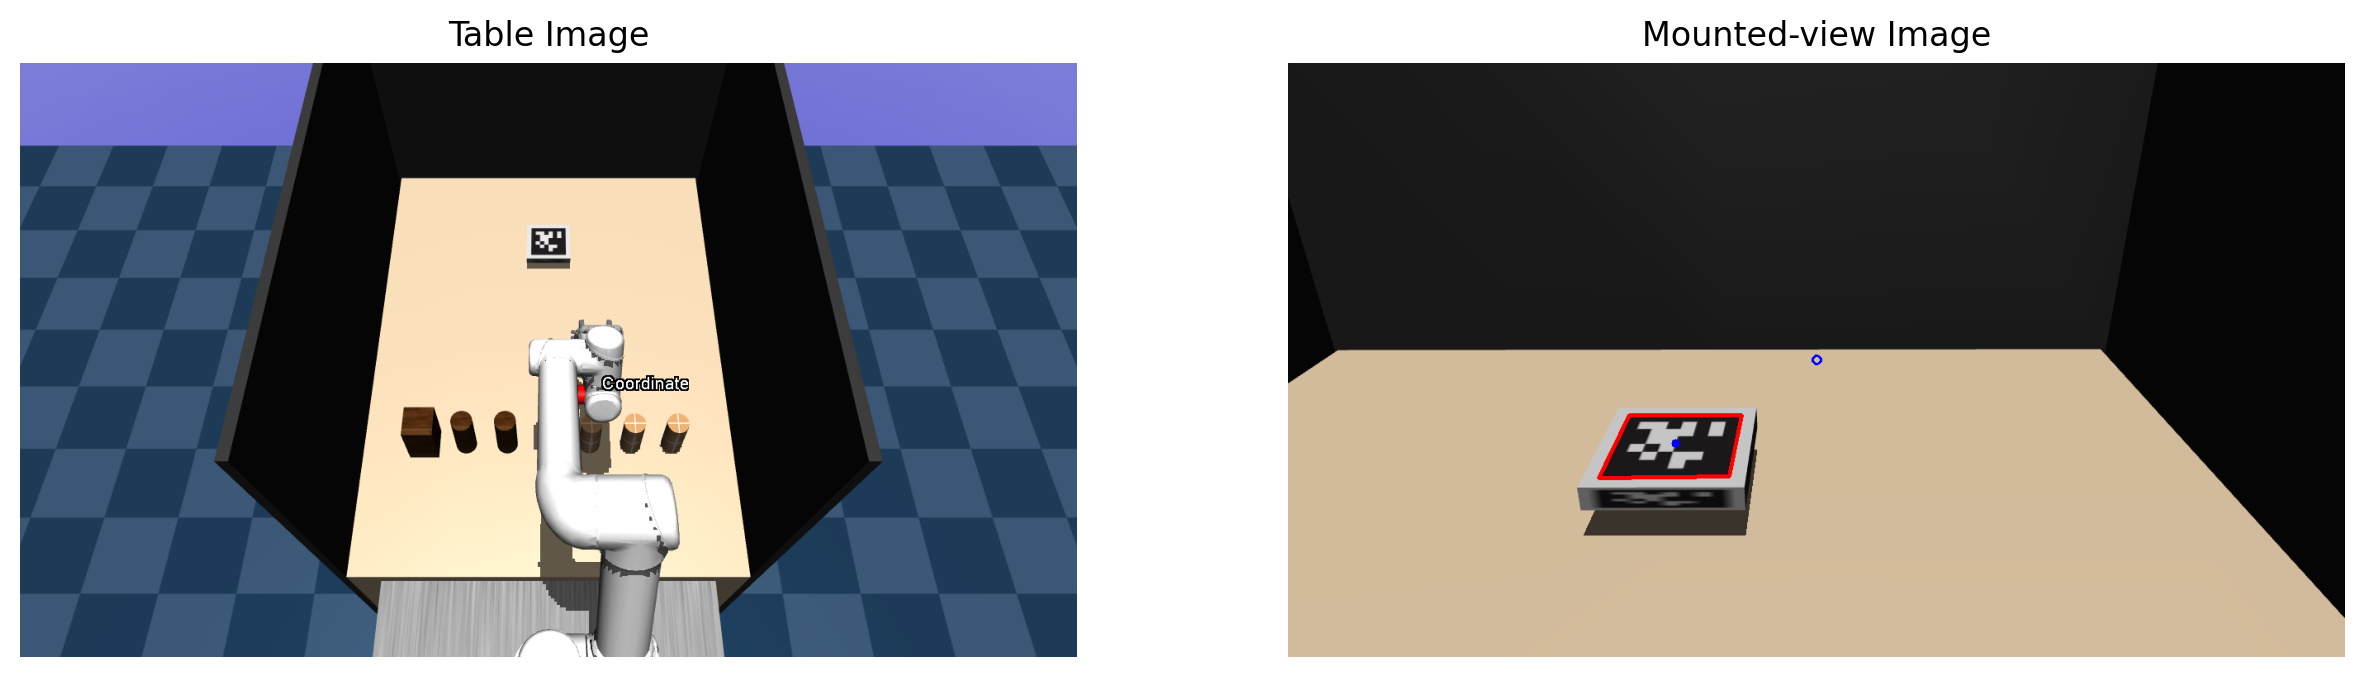

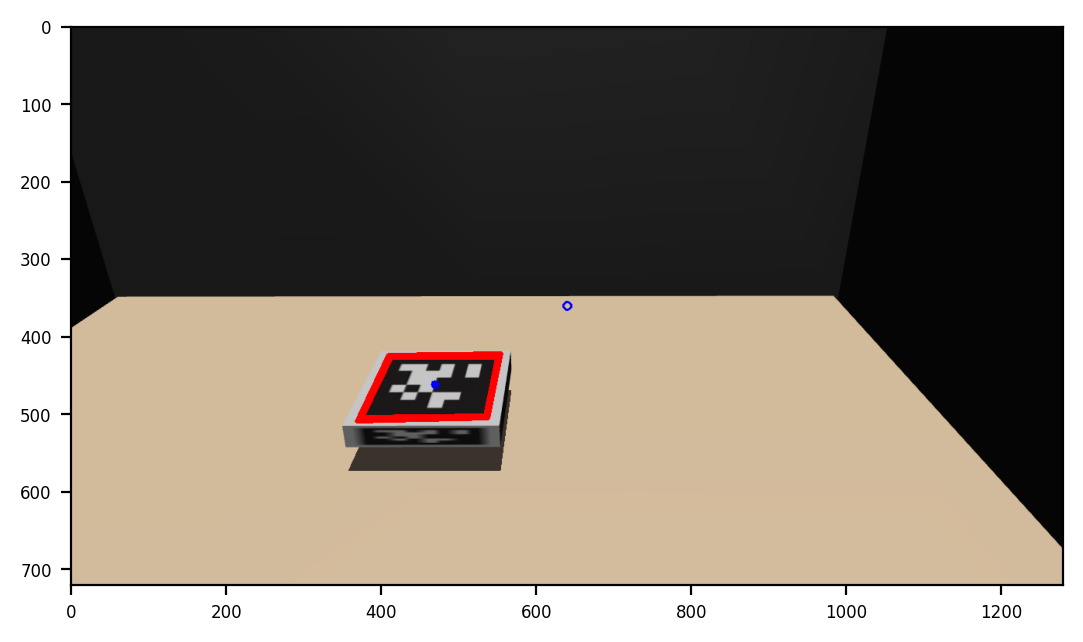

Transformation matrix about 'from link': ur_rg2_gripper_base_link
[[-3.28e-03 -4.14e-01  9.10e-01  7.57e-01]
 [-1.00e+00  1.58e-04 -3.53e-03 -1.12e-01]
 [ 1.32e-03 -9.10e-01 -4.14e-01  1.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
Transformation matrix about 'to link': ur_base_link
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'from2to' link: ur_rg2_gripper_base_link -> ur_base_link
[[-3.28e-03 -1.00e+00  1.32e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  4.32e-01]
 [ 9.10e-01 -3.53e-03 -4.14e-01 -4.38e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
[[ 1.   -0.02 -0.02  0.08]
 [-0.01  0.43 -0.9   0.47]
 [ 0.02  0.9   0.43 -0.35]
 [ 0.    0.    0.    1.  ]]
[[-3.28e-03 -1.00e+00  1.32e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  4.32e-01]
 [ 9.10e-01 -3.53e-03 -4.14e-01 -4.38e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
data saved completely.


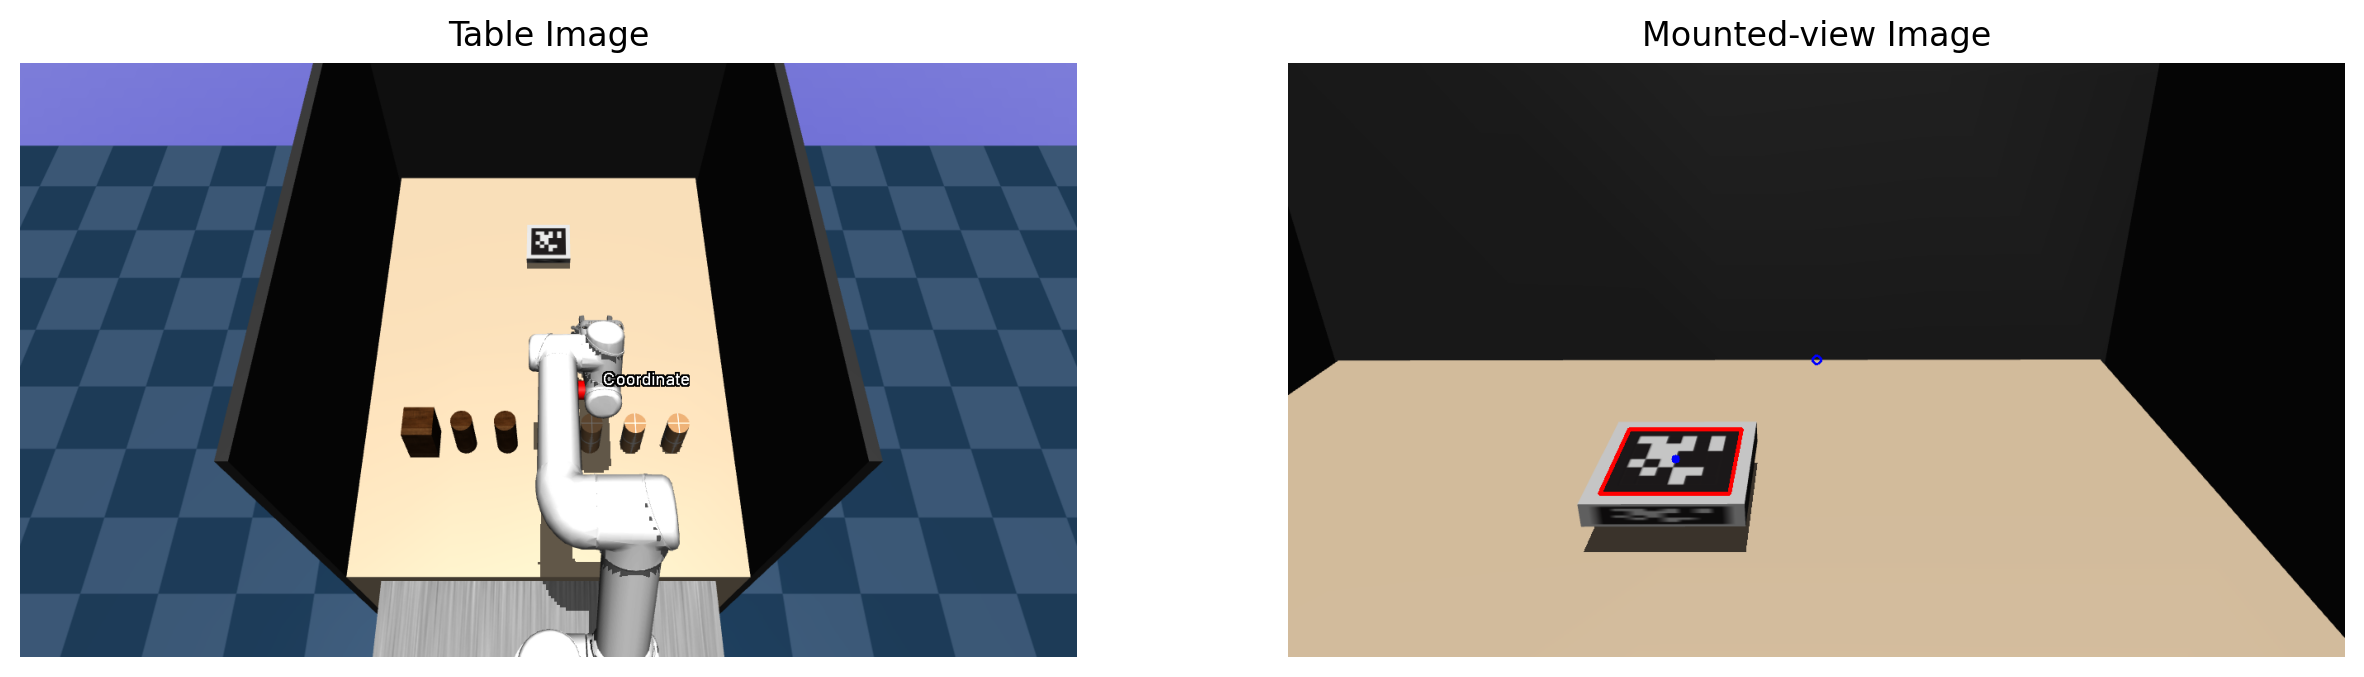

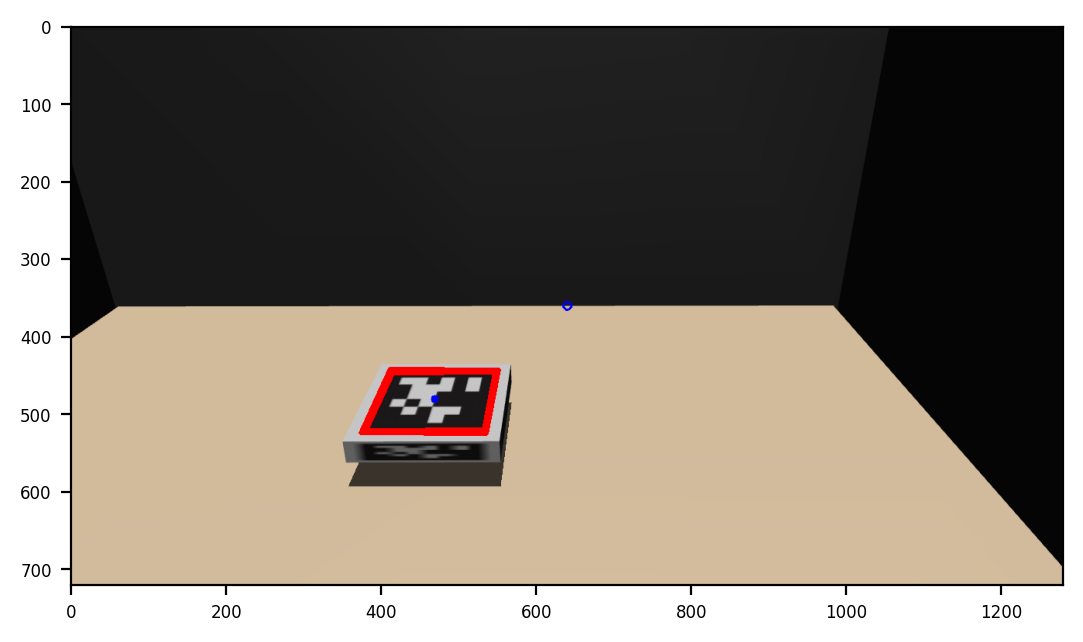

Transformation matrix about 'from link': ur_rg2_gripper_base_link
[[-3.27e-03 -4.14e-01  9.10e-01  7.61e-01]
 [-1.00e+00  1.58e-04 -3.52e-03 -1.12e-01]
 [ 1.31e-03 -9.10e-01 -4.14e-01  1.01e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
Transformation matrix about 'to link': ur_base_link
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'from2to' link: ur_rg2_gripper_base_link -> ur_base_link
[[-3.27e-03 -1.00e+00  1.31e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  4.44e-01]
 [ 9.10e-01 -3.52e-03 -4.14e-01 -4.37e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
[[ 1.    0.    0.01  0.07]
 [ 0.01  0.39 -0.92  0.49]
 [-0.01  0.92  0.39 -0.33]
 [ 0.    0.    0.    1.  ]]
[[-3.27e-03 -1.00e+00  1.31e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  4.44e-01]
 [ 9.10e-01 -3.52e-03 -4.14e-01 -4.37e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
data saved completely.


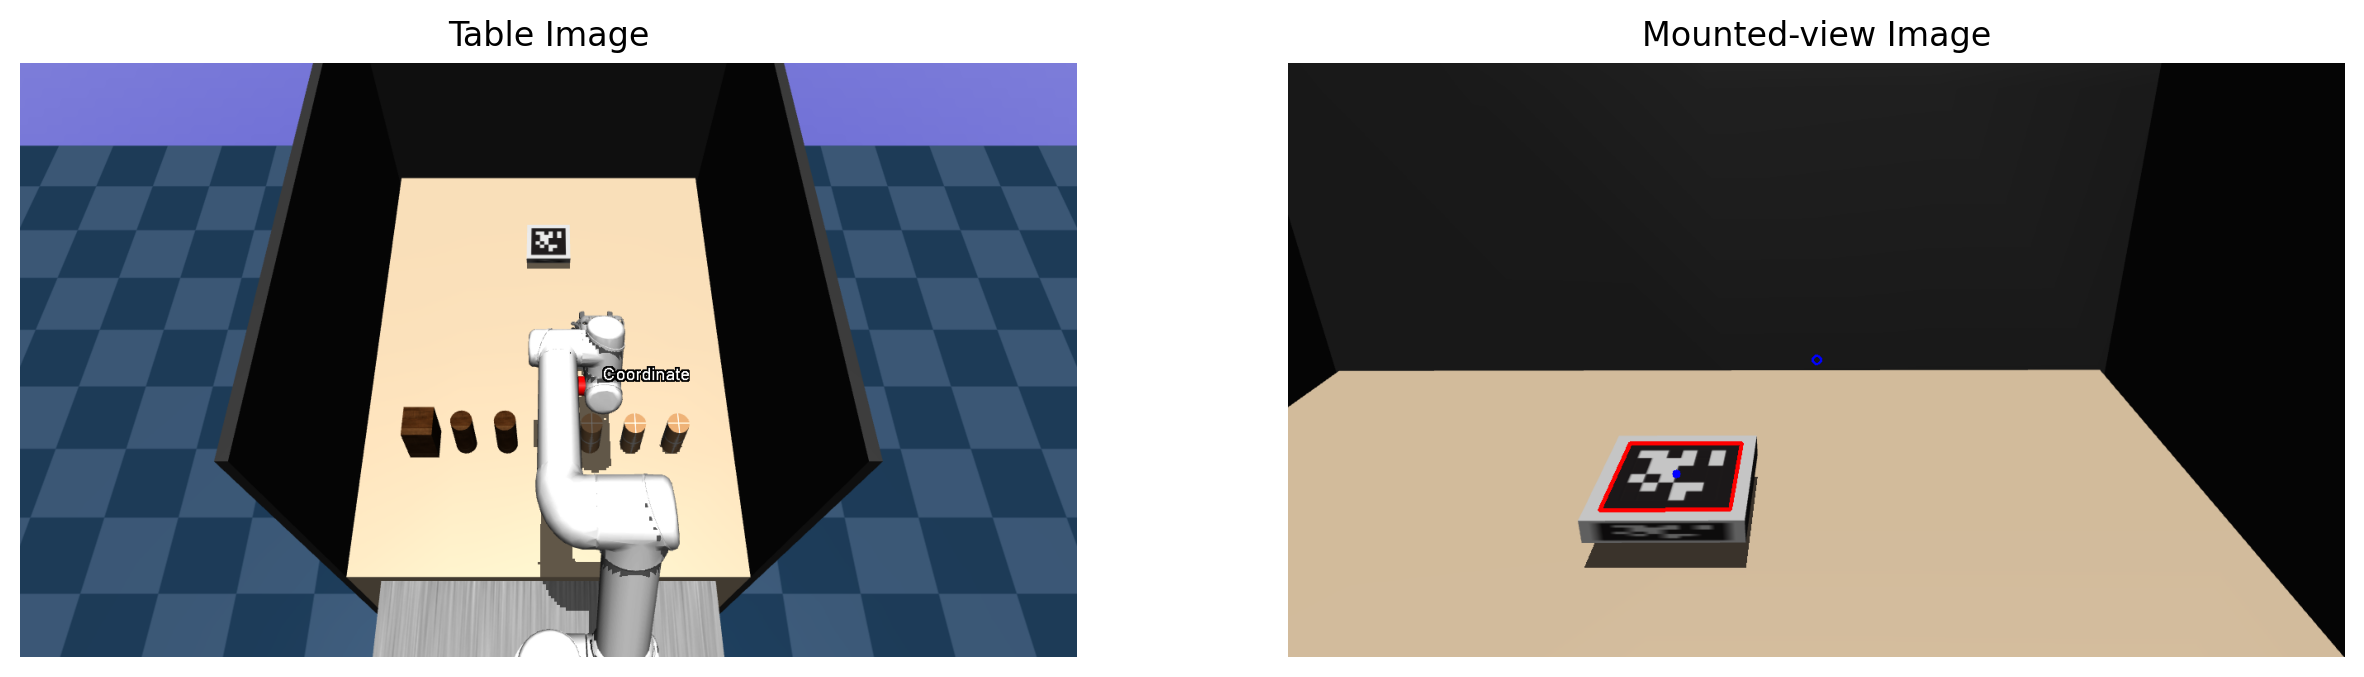

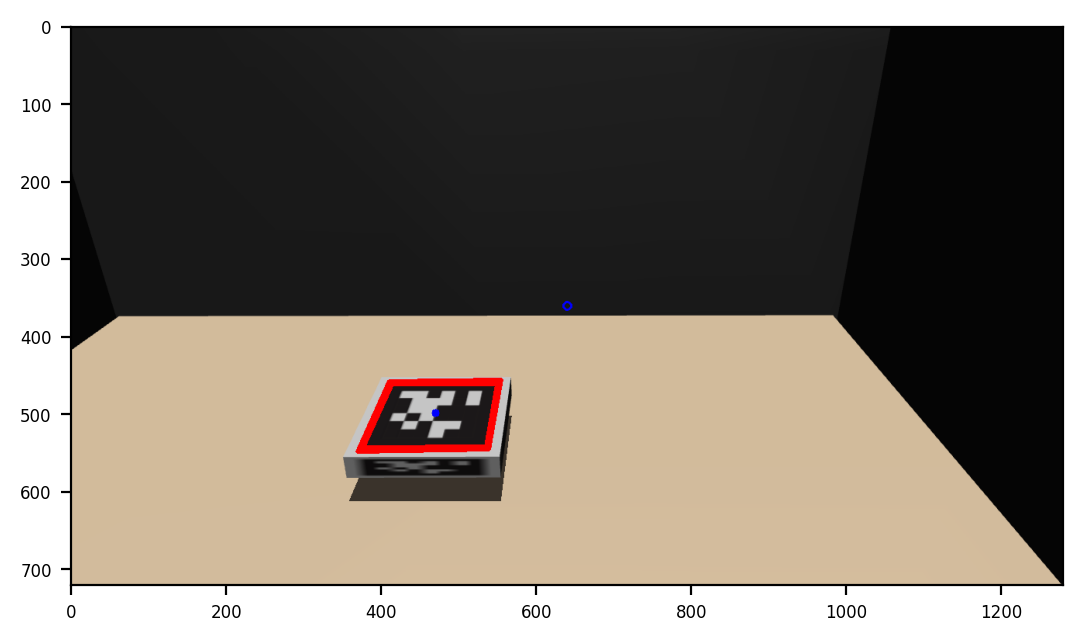

Transformation matrix about 'from link': ur_rg2_gripper_base_link
[[-3.25e-03 -4.14e-01  9.10e-01  7.65e-01]
 [-1.00e+00  1.58e-04 -3.50e-03 -1.12e-01]
 [ 1.31e-03 -9.10e-01 -4.14e-01  1.02e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
Transformation matrix about 'to link': ur_base_link
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'from2to' link: ur_rg2_gripper_base_link -> ur_base_link
[[-3.25e-03 -1.00e+00  1.31e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  4.56e-01]
 [ 9.10e-01 -3.50e-03 -4.14e-01 -4.36e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
[[ 1.   -0.02 -0.01  0.1 ]
 [-0.    0.43 -0.9   0.47]
 [ 0.02  0.9   0.43 -0.35]
 [ 0.    0.    0.    1.  ]]
[[-3.25e-03 -1.00e+00  1.31e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  4.56e-01]
 [ 9.10e-01 -3.50e-03 -4.14e-01 -4.36e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
data saved completely.


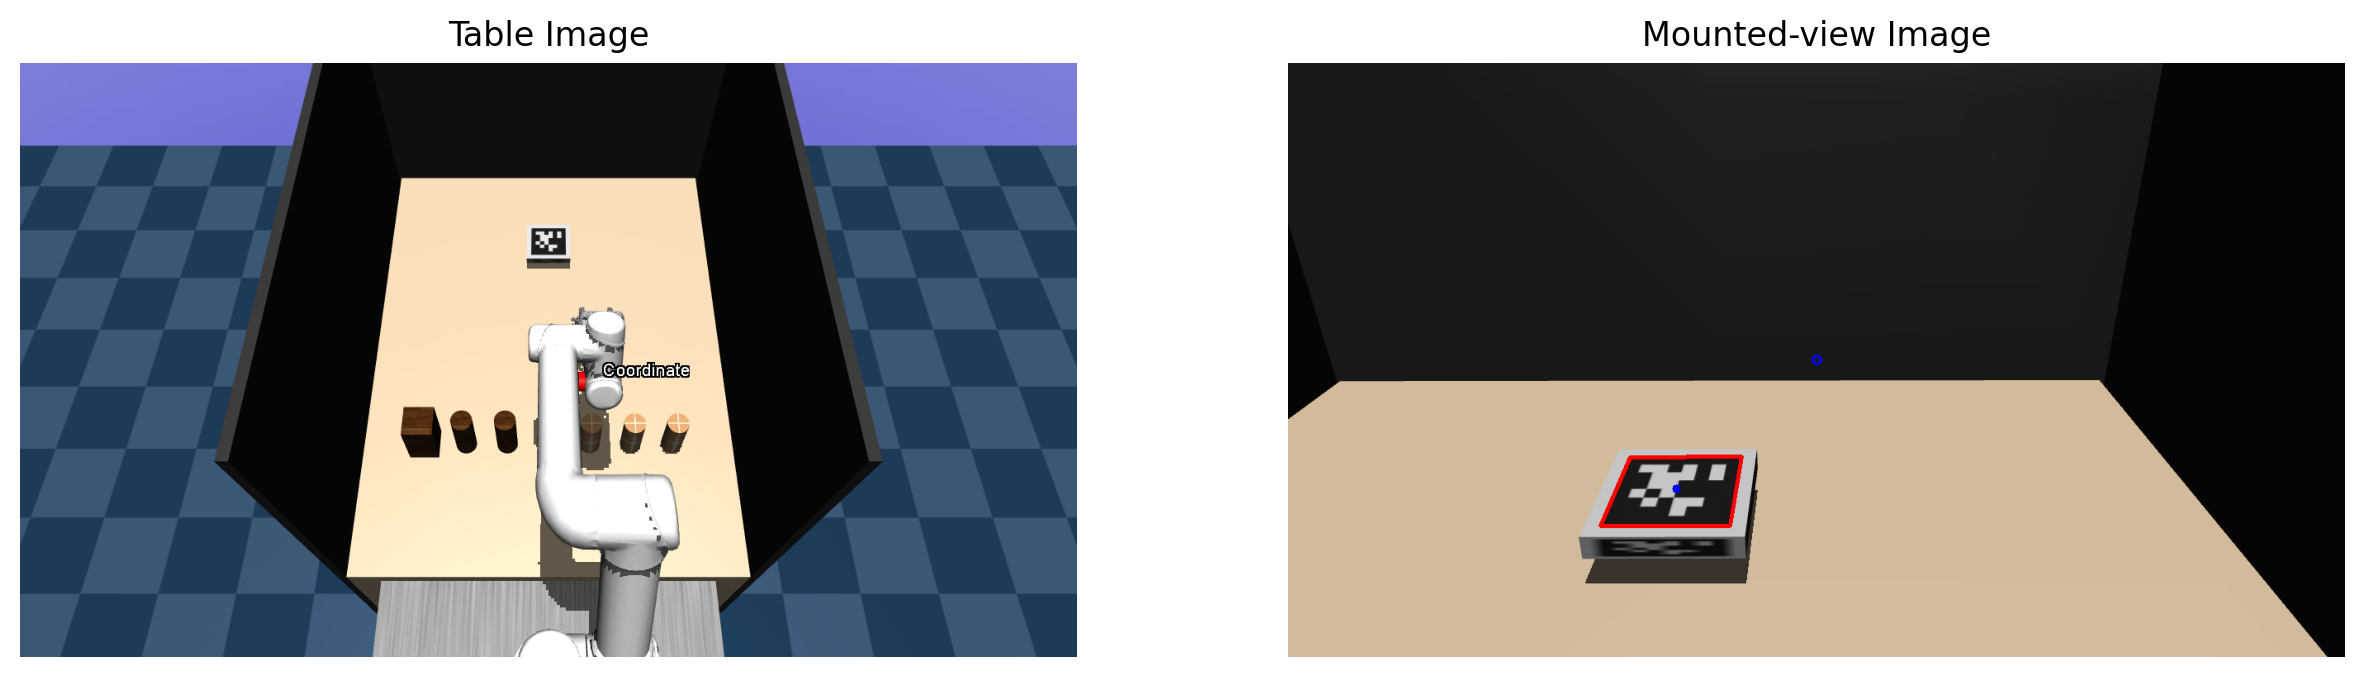

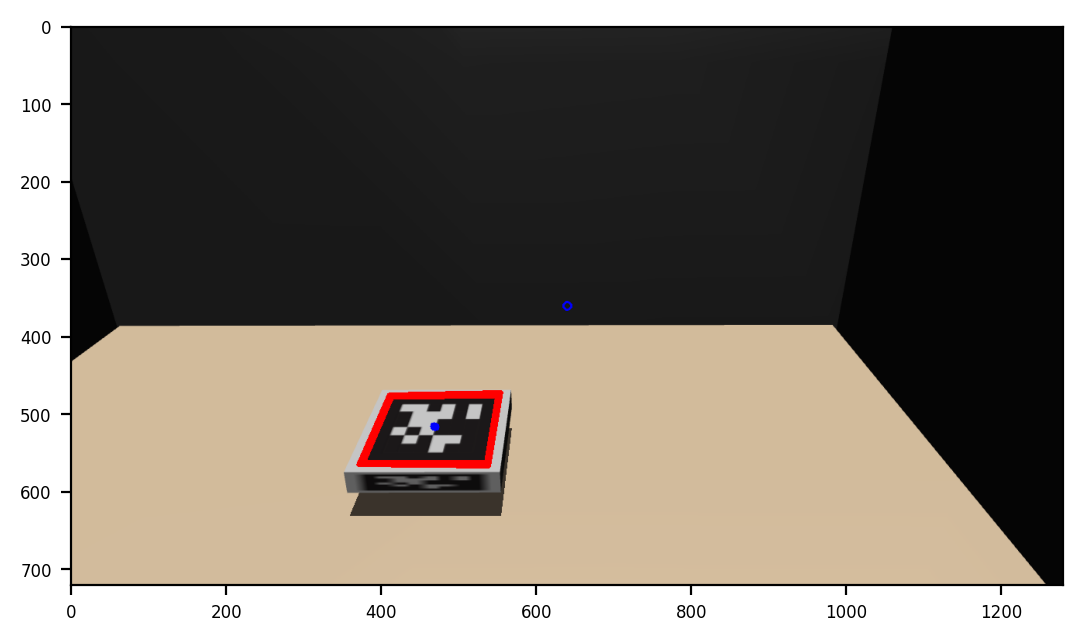

Transformation matrix about 'from link': ur_rg2_gripper_base_link
[[-3.24e-03 -4.14e-01  9.10e-01  7.69e-01]
 [-1.00e+00  1.58e-04 -3.49e-03 -1.12e-01]
 [ 1.30e-03 -9.10e-01 -4.14e-01  1.04e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
Transformation matrix about 'to link': ur_base_link
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'from2to' link: ur_rg2_gripper_base_link -> ur_base_link
[[-3.24e-03 -1.00e+00  1.30e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  4.68e-01]
 [ 9.10e-01 -3.49e-03 -4.14e-01 -4.34e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
[[ 1.   -0.   -0.    0.11]
 [-0.    0.44 -0.9   0.47]
 [ 0.    0.9   0.44 -0.36]
 [ 0.    0.    0.    1.  ]]
[[-3.24e-03 -1.00e+00  1.30e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  4.68e-01]
 [ 9.10e-01 -3.49e-03 -4.14e-01 -4.34e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
data saved completely.


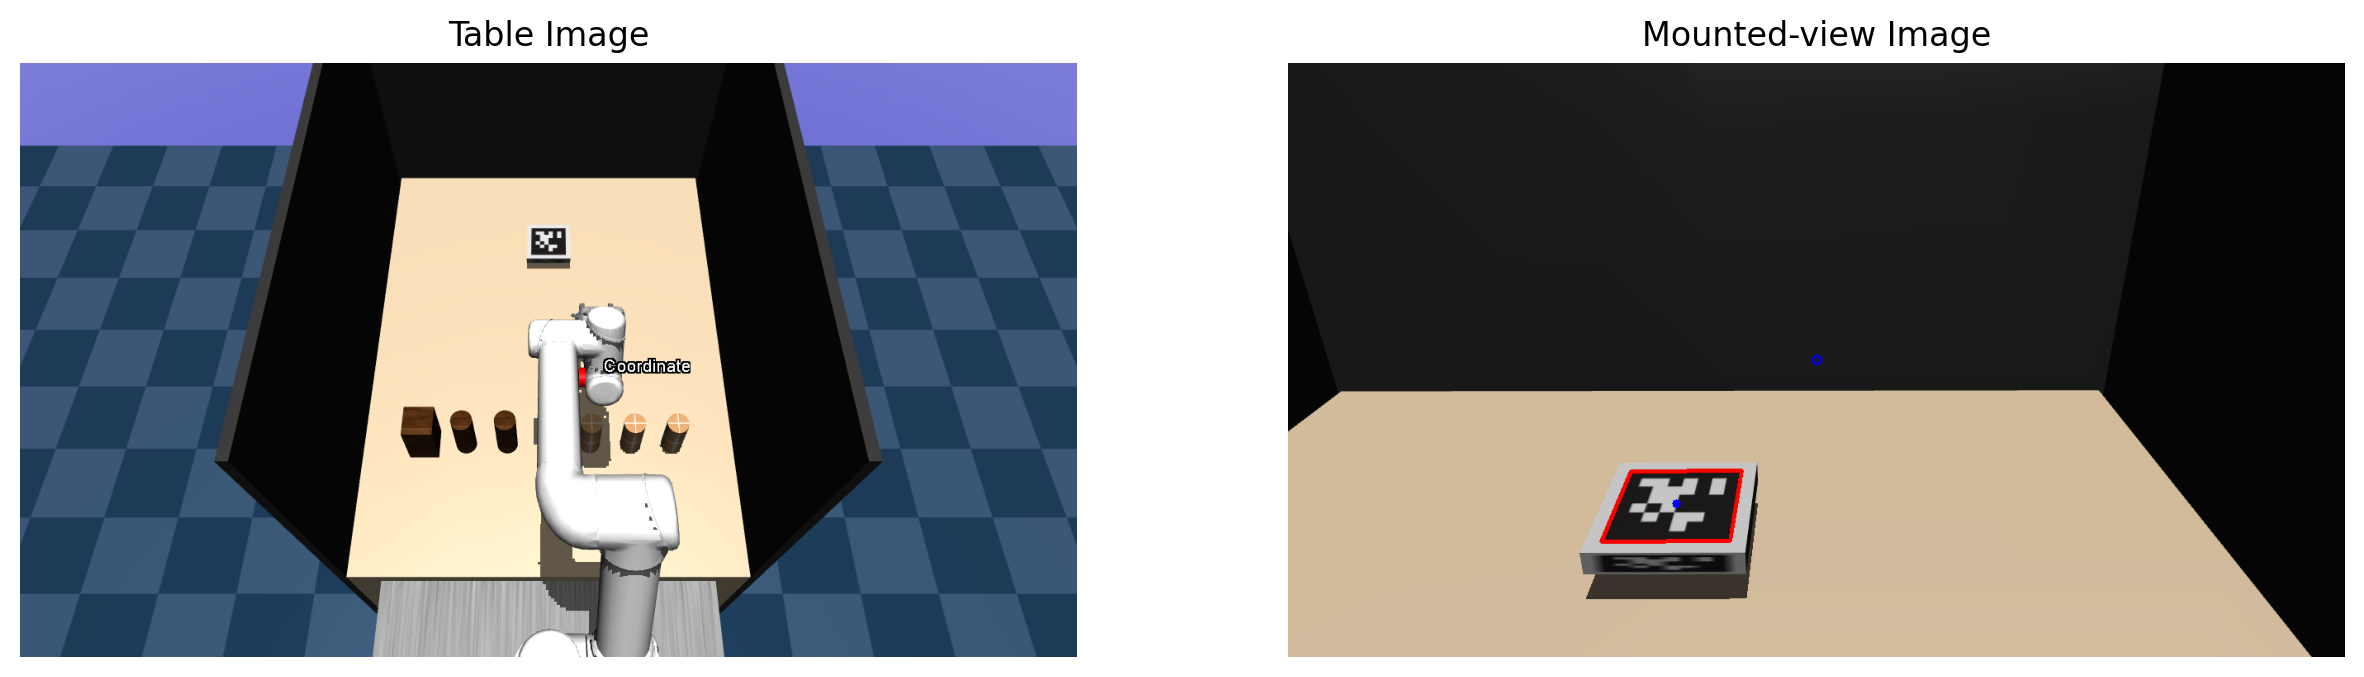

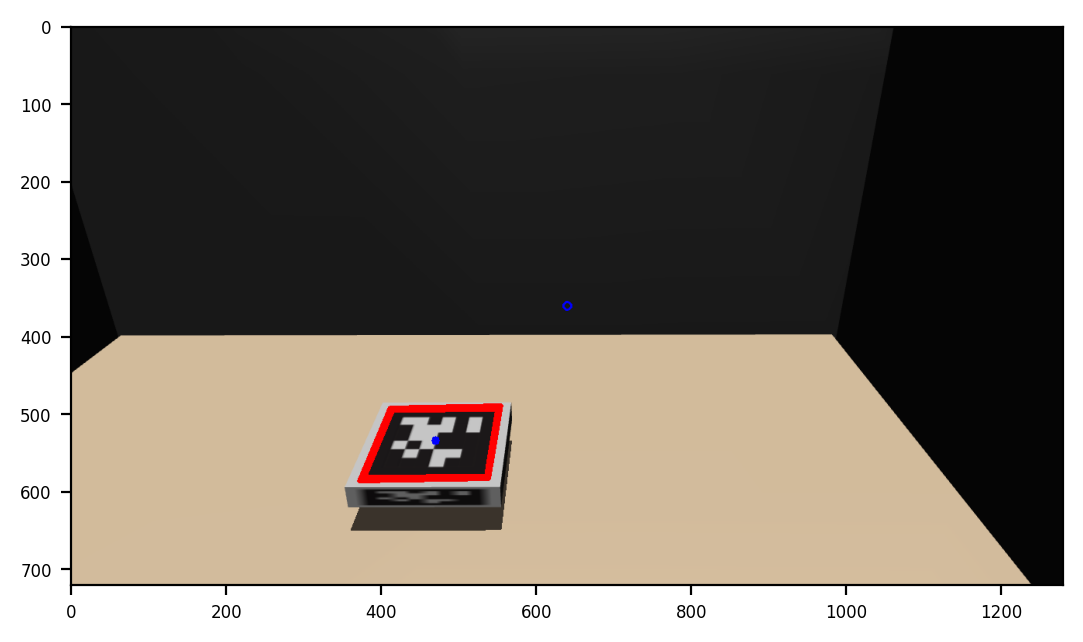

Transformation matrix about 'from link': ur_rg2_gripper_base_link
[[-3.23e-03 -4.14e-01  9.10e-01  7.72e-01]
 [-1.00e+00  1.58e-04 -3.47e-03 -1.12e-01]
 [ 1.29e-03 -9.10e-01 -4.14e-01  1.05e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
Transformation matrix about 'to link': ur_base_link
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'from2to' link: ur_rg2_gripper_base_link -> ur_base_link
[[-3.23e-03 -1.00e+00  1.29e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  4.81e-01]
 [ 9.10e-01 -3.47e-03 -4.14e-01 -4.32e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
[[ 1.   -0.02 -0.01  0.12]
 [-0.    0.43 -0.9   0.48]
 [ 0.02  0.9   0.43 -0.35]
 [ 0.    0.    0.    1.  ]]
[[-3.23e-03 -1.00e+00  1.29e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  4.81e-01]
 [ 9.10e-01 -3.47e-03 -4.14e-01 -4.32e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
data saved completely.


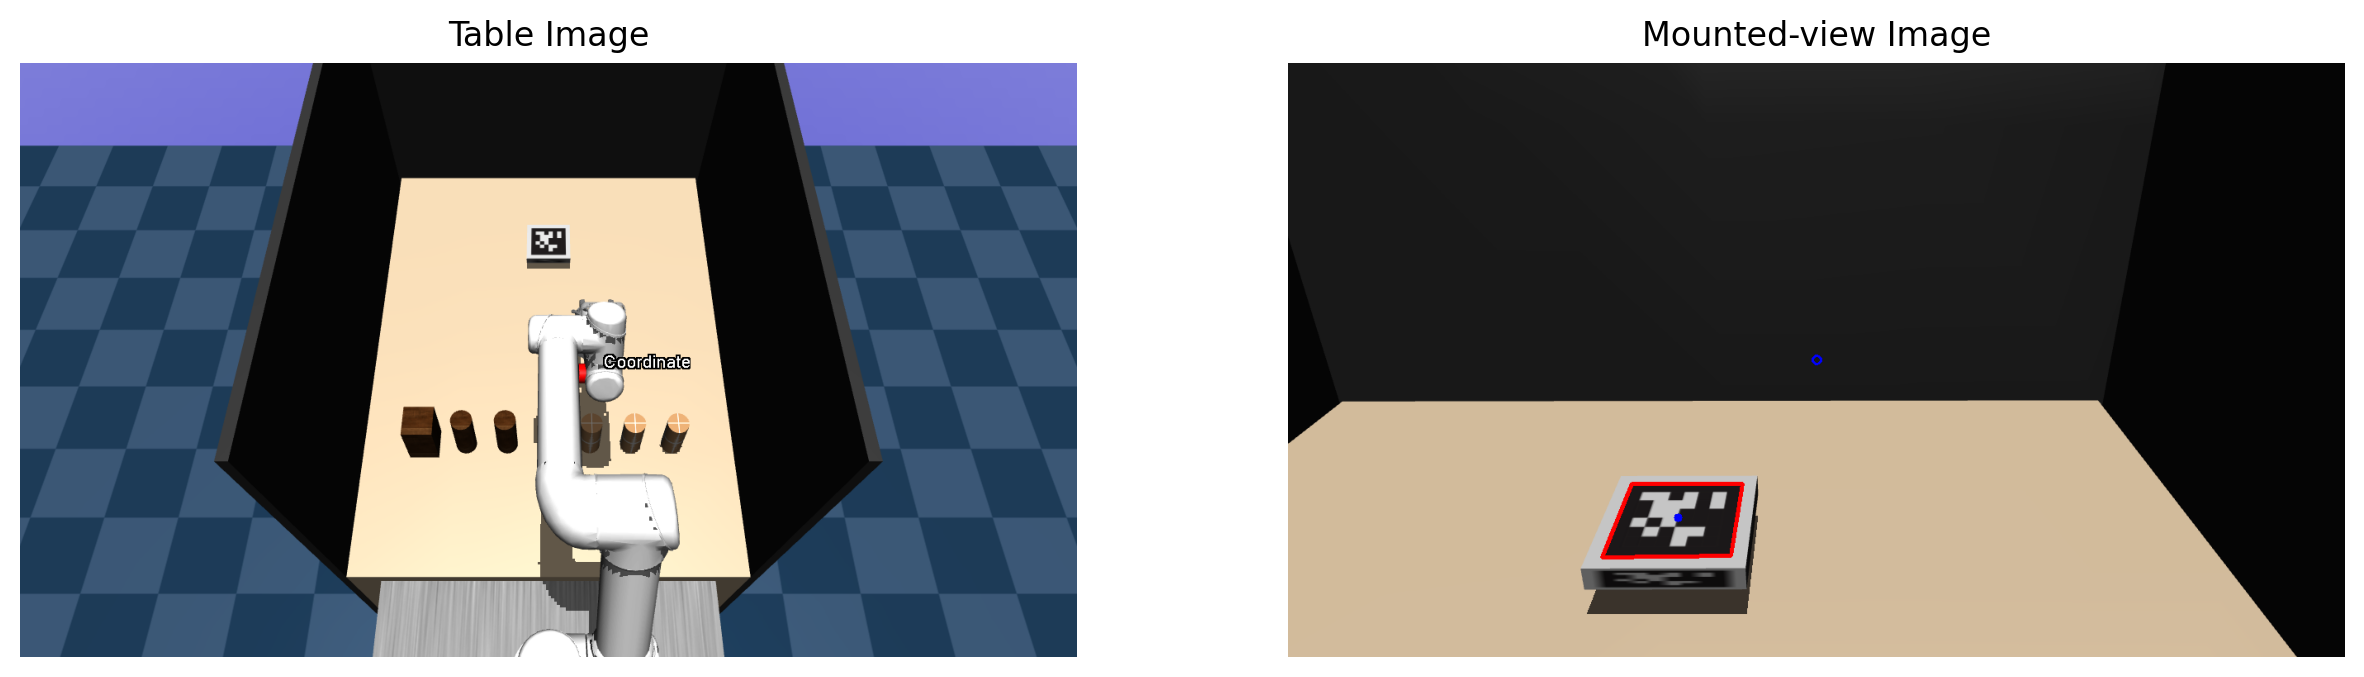

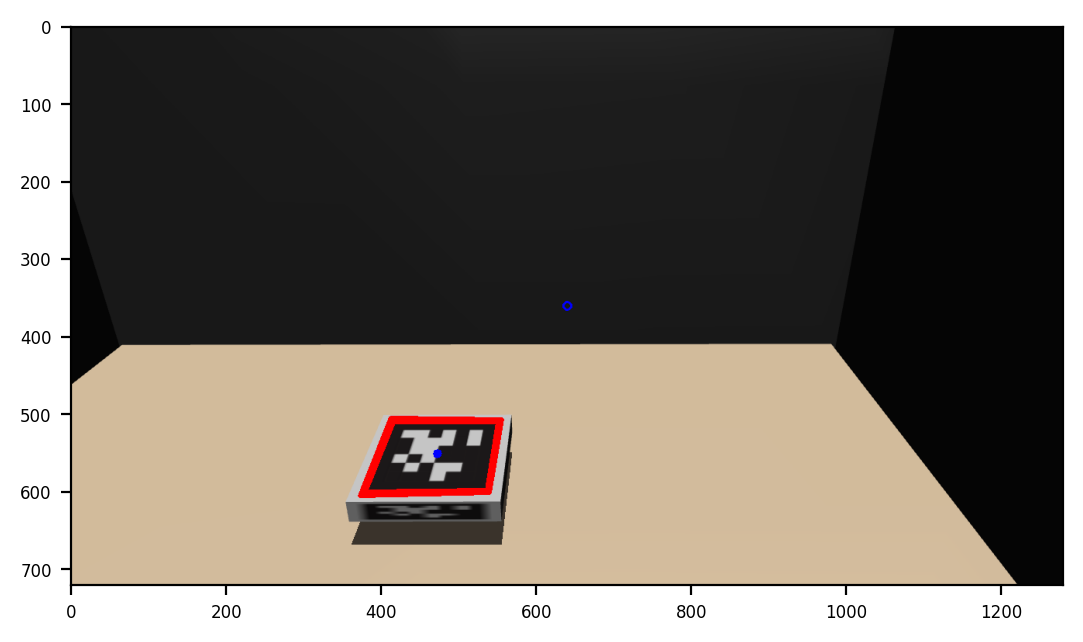

Transformation matrix about 'from link': ur_rg2_gripper_base_link
[[-3.21e-03 -4.14e-01  9.10e-01  7.75e-01]
 [-1.00e+00  1.58e-04 -3.46e-03 -1.12e-01]
 [ 1.29e-03 -9.10e-01 -4.14e-01  1.06e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
Transformation matrix about 'to link': ur_base_link
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'from2to' link: ur_rg2_gripper_base_link -> ur_base_link
[[-3.21e-03 -1.00e+00  1.29e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  4.93e-01]
 [ 9.10e-01 -3.46e-03 -4.14e-01 -4.30e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
[[ 1.   -0.01 -0.01  0.13]
 [-0.    0.43 -0.9   0.48]
 [ 0.01  0.9   0.43 -0.35]
 [ 0.    0.    0.    1.  ]]
[[-3.21e-03 -1.00e+00  1.29e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  4.93e-01]
 [ 9.10e-01 -3.46e-03 -4.14e-01 -4.30e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
data saved completely.


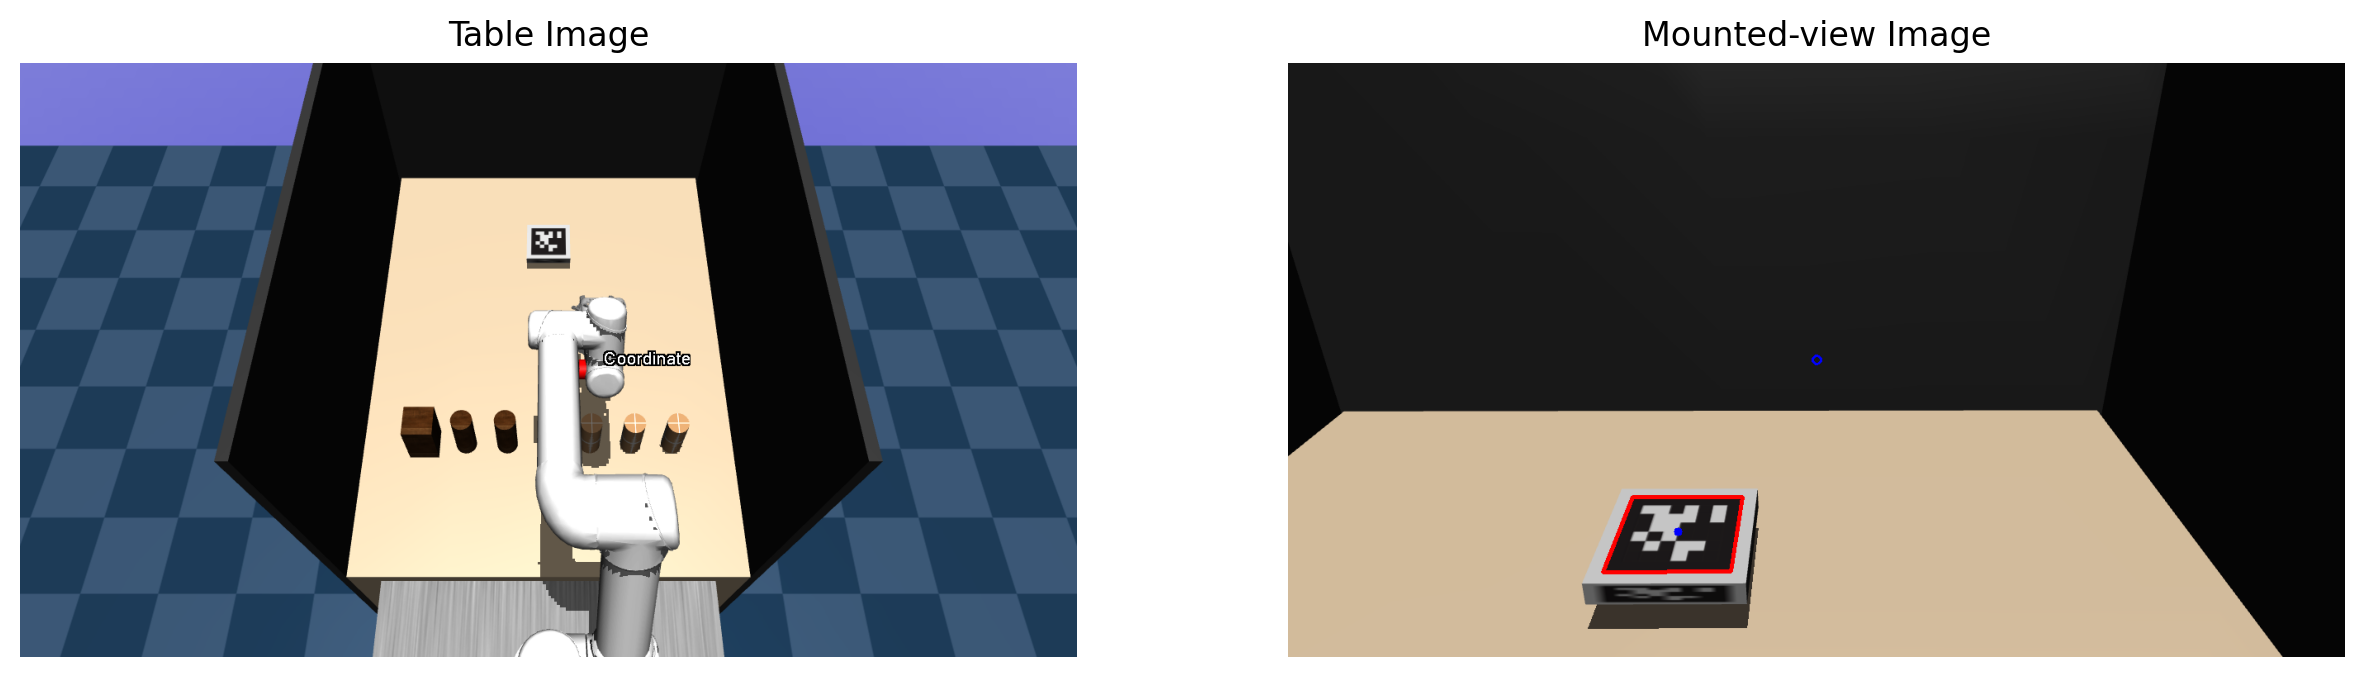

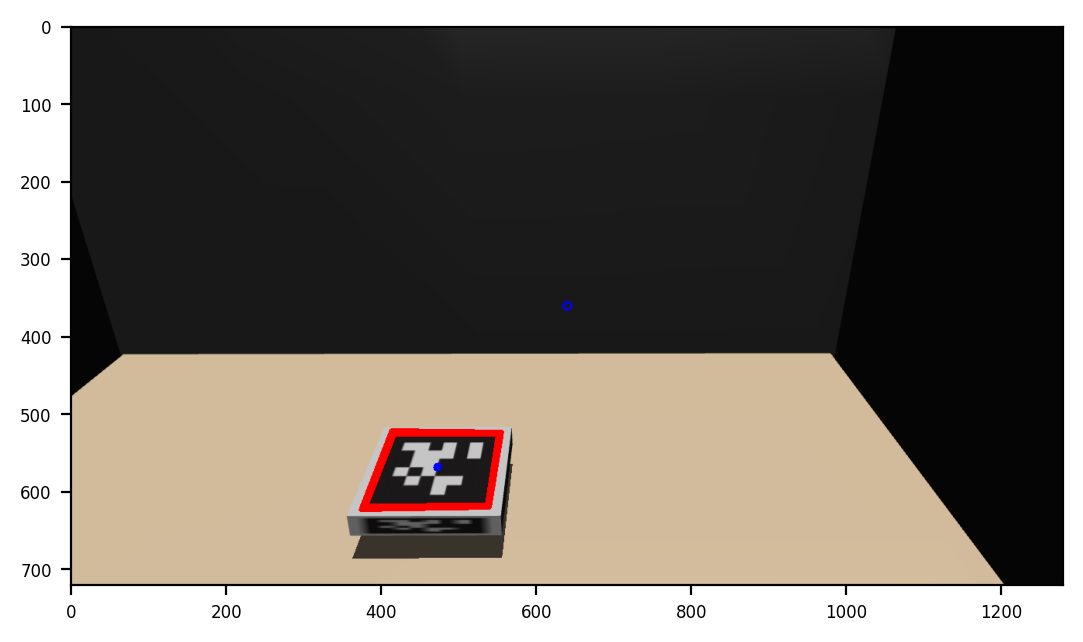

Transformation matrix about 'from link': ur_rg2_gripper_base_link
[[-3.20e-03 -4.14e-01  9.10e-01  7.77e-01]
 [-1.00e+00  1.58e-04 -3.44e-03 -1.12e-01]
 [ 1.28e-03 -9.10e-01 -4.14e-01  1.07e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
Transformation matrix about 'to link': ur_base_link
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'from2to' link: ur_rg2_gripper_base_link -> ur_base_link
[[-3.20e-03 -1.00e+00  1.28e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  5.05e-01]
 [ 9.10e-01 -3.44e-03 -4.14e-01 -4.27e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
[[ 1.   -0.01 -0.01  0.15]
 [-0.01  0.43 -0.9   0.48]
 [ 0.01  0.9   0.43 -0.35]
 [ 0.    0.    0.    1.  ]]
[[-3.20e-03 -1.00e+00  1.28e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  5.05e-01]
 [ 9.10e-01 -3.44e-03 -4.14e-01 -4.27e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
data saved completely.


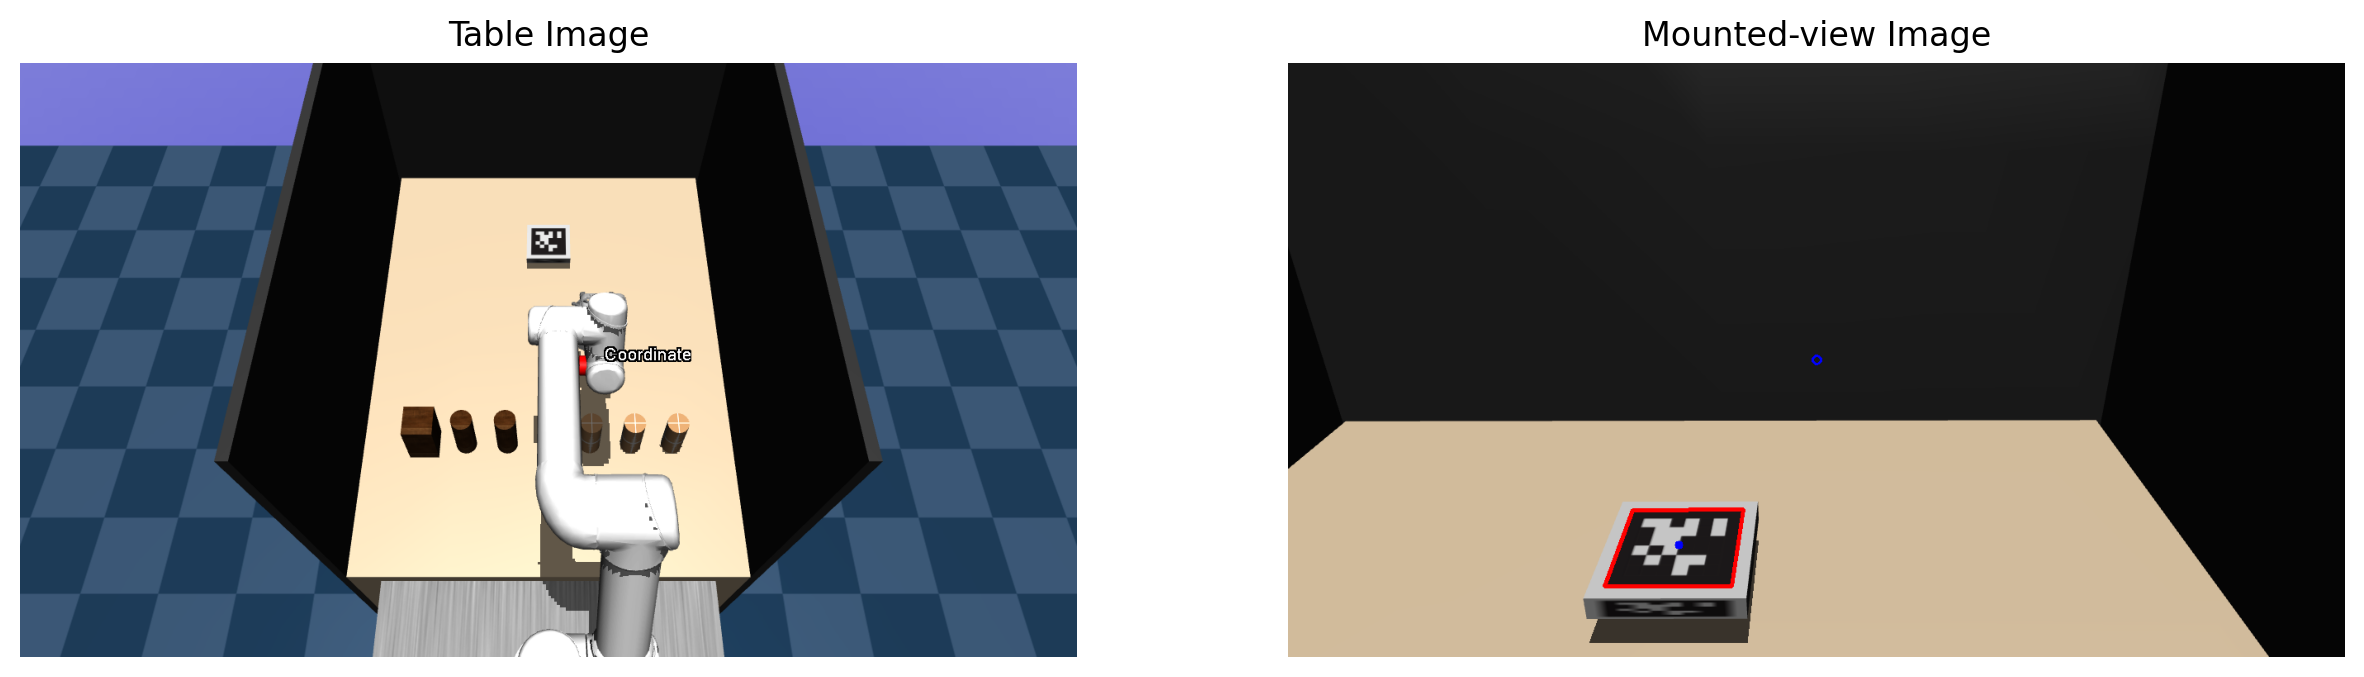

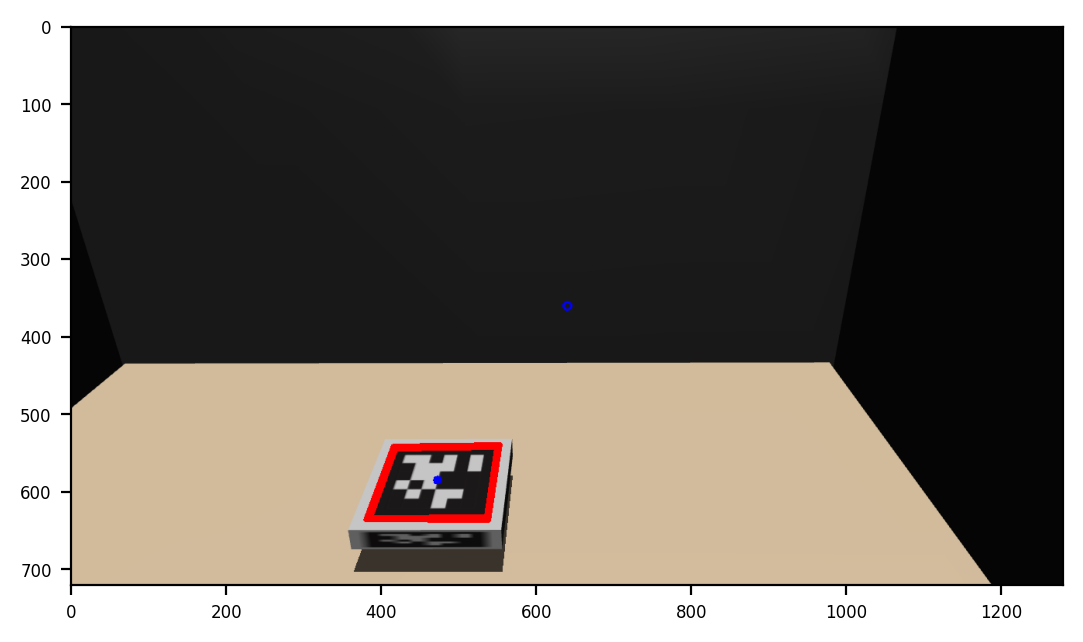

Transformation matrix about 'from link': ur_rg2_gripper_base_link
[[-3.19e-03 -4.14e-01  9.10e-01  7.80e-01]
 [-1.00e+00  1.58e-04 -3.43e-03 -1.12e-01]
 [ 1.27e-03 -9.10e-01 -4.14e-01  1.08e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
Transformation matrix about 'to link': ur_base_link
[[1.   0.   0.   0.18]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.79]
 [0.   0.   0.   1.  ]]
Transformation matrix about 'from2to' link: ur_rg2_gripper_base_link -> ur_base_link
[[-3.19e-03 -1.00e+00  1.27e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  5.16e-01]
 [ 9.10e-01 -3.43e-03 -4.14e-01 -4.24e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
[[ 1.   -0.    0.01  0.15]
 [ 0.01  0.39 -0.92  0.5 ]
 [-0.    0.92  0.39 -0.34]
 [ 0.    0.    0.    1.  ]]
[[-3.19e-03 -1.00e+00  1.27e-03 -1.10e-01]
 [-4.14e-01  1.58e-04 -9.10e-01  5.16e-01]
 [ 9.10e-01 -3.43e-03 -4.14e-01 -4.24e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
data saved completely.


In [56]:
import math

bs2ee_list = []
tagpose_list = []
camera_pos_list = []
p_eef_list = []
cam_infos = []

# delete all the markers.
del env.viewer._markers[:]

# Check available objects whose names start with 'obj_'
# Set objects behind of apriltag
obj_names = get_env_obj_names(env,prefix='obj_') # see objects
for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [0.7,-0.3+0.1*obj_idx,0.8]
    obj_quat  = [0,0,0,1]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=None)

# Set AprilTag configurations
april_addr_z = env.sim.model.get_joint_qpos_addr('box_checker_z')
env.sim.data.qpos[april_addr_z] = -math.pi/2

init_configurations = [0, 0, 0, 0, 0, 0]
set_env_joint_configuration(env, init_configurations, prefix='ur_')

# update object, robot configurations
env.step()
env.forward(INCREASE_TICK=False)

file_name = 0
max_tick = 10
env.tick = 0

while env.tick < max_tick:
    # Set Joint Configurations
    init_configurations = [-math.pi, -2.0, -math.pi/2+0.01*env.tick*math.pi, -math.pi-0.01*env.tick*math.pi, -math.pi/2, 0.]
    set_env_joint_configuration(env, init_configurations, prefix='ur_')

    # update object, robot configurations
    env.step()
    env.forward(INCREASE_TICK=False)

    # Get pose what I want to attach on.
    p_eef = env.get_p_body("ur_wrist_3_link")
    R_eef = env.get_R_body("ur_wrist_3_link")
    p_eef_list.append(p_eef)
    
    axis_len = 0.18
    p_z = p_eef - R_z[:,2]*axis_len/2
    R_z = R_eef@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,0,1]))

    # Add viewer coordinate marker.
    env.add_marker_coordinate(
        p=p_eef,R=R_eef,axis_len=0.05,axis_width=0.02,label='Coordinate')

    R_z_rpy = np.degrees(r2rpy(R_z))
    
    # View Up-right the table.
    cam_table = env.set_cam_infos(cam_distance  = 1.0,
                        cam_azimuth   = 0,   # Z-axis: Yaw
                        cam_elevation = -60,      # X-axis: Roll                        
                        cam_lookat    = [0.5, 0, 1.5])  # arbitrary offset on camera.

    for _ in range(5):
        img_table = env.render_scene(mode='rgb_array', cam_infos=cam_table, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(img_table); plt.axis('off')
    plt.title("Table Image")

    # Follow Robot end-effector.
    cam_infos = env.set_cam_infos(cam_distance  = -0.09,
                        cam_azimuth   = R_z_rpy[2]+90,        # Z-axis: Yaw
                        cam_elevation = R_z_rpy[0]+180,      # X-axis: Roll                        
                        cam_lookat    = p_z)  # arbitrary offset on camera.

    camera_pos_list.append(cam_infos["cam_lookat"])

    env.forward(INCREASE_TICK=False)

    for _ in range(2):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
        img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=True, camera_name="track")
        img_real = np.array(env.depth2meters(img_depth))

    detector = apriltag.Detector()
    img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
    results = detector.detect(img_Gray)
    draw_bbox(results, img, verbose=False)


    plt.subplot(1,2,2)
    plt.imshow(img); plt.axis('off')
    plt.title("Mounted-view Image")
    plt.show()

    # Get matrix A.
    tagpose = get_apriltag_pose(env, img, img_depth)
    tagpose_list.append(tagpose)

    # Get matrix B.
    bs2ee_matrix = get_homogeneous_matrix(env, from_link='ur_base_link', to_link='ur_rg2_gripper_base_link', verbose=False)
    bs2ee_list.append(bs2ee_matrix)

    get_calibration_data(env, img, img_depth, from_link='ur_rg2_gripper_base_link', to_link='ur_base_link', file_name=file_name, verbose=True)
    file_name += 1

    # delete all the markers.
    del env.viewer._markers[:]

    # img = []
    # cam_infos = []

In [57]:
import sys
sys.path.append("..")
from util_calibration import get_extrinsic_calibration_frank, get_extrinsic_calibration_tsai

In [67]:
R_ee2bs = [np.load(f"./data/20230215/R_ee2bs_{i}.npy") for i in range(10)]
p_ee2bs = [np.load(f"./data/20230215/p_ee2bs_{i}.npy") for i in range(10)]
R_target2cam = [np.load(f"./data/20230215/R_target2cam_{i}.npy") for i in range(10)]
p_target2cam = [np.load(f"./data/20230215/p_target2cam_{i}.npy") for i in range(10)]


In [68]:
R_ext, p_ext = cv2.calibrateHandEye(R_ee2bs, p_ee2bs, R_target2cam, p_target2cam, method=cv2.CALIB_HAND_EYE_DANIILIDIS)
T_ext = cv2.hconcat((R_ext, p_ext))      # 3x4
T_ext = np.vstack((T_ext, np.array([0,0,0,1])))   # 4x4
T_ext

array([[ 0.33,  0.49,  0.81,  0.08],
       [ 0.19, -0.87,  0.45, -0.07],
       [ 0.92,  0.  , -0.38, -0.11],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

In [69]:
cam_infos["cam_lookat"]

array([ 0.74, -0.11,  1.2 ])

In [70]:
cam_infos["cam_lookat"]-env.get_p_body("ur_wrist_3_link")   

array([ 3.72e-02, -1.40e-05,  8.20e-02])

In [35]:
p_ext

array([[ 1.  ],
       [ 0.18],
       [-0.28]])

In [36]:
R_ext

array([[ 0.38, -0.68,  0.63],
       [-0.92, -0.36,  0.17],
       [ 0.11, -0.64, -0.76]])

In [26]:
A = bs2ee_list
B = tagpose_list

In [27]:
get_extrinsic_calibration_frank(A, B)

array([[-0.35, -0.24,  0.9 ,  0.39],
       [-0.2 , -0.92, -0.33, -0.  ],
       [ 0.91, -0.3 ,  0.28,  0.17],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

In [28]:
get_extrinsic_calibration_tsai(A, B)

array([[-0.07,  0.62,  0.78,  0.56],
       [-0.82,  0.4 , -0.4 , -0.21],
       [-0.56, -0.67,  0.48,  0.43],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])